In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Decoding the Comments: Sentiment, Topics, and Predictive Insights

The comments section is often referred to as the "pulse" of online communities, offering an unfiltered view of audience sentiment, engagement, and reactions. In this final notebook of the project, we shift our focus to the comments dataset to uncover deeper insights about the audience and their interactions with video content.

Through a combination of **data analysis** and **machine learning techniques**, this notebook will explore the following key areas:
- **Sentiment Analysis**: Understanding the emotional tone of user comments and its correlation with video engagement.
- **Topic Modeling**: Uncovering recurring themes and patterns in audience discussions.
- **Predictive Modeling**: Using comments to predict engagement metrics and identify key drivers of interaction.
- **Advanced NLP**: Applying modern Natural Language Processing (NLP) techniques to classify sentiment, detect emotions, and extract nuanced insights.

This notebook not only aims to generate actionable insights but also demonstrates the application of machine learning and NLP tools to real-world data. By the end, we hope to bridge the gap between content creators and their audience, providing a clearer understanding of how comments reflect and influence engagement.

As the final notebook in this series, this analysis will tie together the insights from previous notebooks, offering a holistic view of how video content and audience interaction shape overall engagement trends.

---
## Imports

In [2]:
! pip install vaderSentiment pyLDAvis

In [36]:
import pandas as pd
import numpy as np
import re
from datetime import datetime
from dateutil import parser
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS, CountVectorizer
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from textblob import TextBlob
from wordcloud import WordCloud, STOPWORDS
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt
import pyLDAvis
import xgboost as xgb
import seaborn as sns
sns.set(style="darkgrid", color_codes=True)
from collections import Counter
from tqdm import tqdm

import transformers
print(transformers.__version__)

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments, pipeline
import torch
from torch.utils.data import Dataset


nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

4.52.4


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

- **pandas** and **numpy**: Essential libraries for data manipulation and numerical operations.
- **datetime** and **dateutil.parser**: Tools for handling and parsing dates.
- **nltk**: Natural Language Toolkit for text processing, including tokenization and stopword removal.
- **sklearn.feature_extraction.text**: Provides built-in English stopwords for text preprocessing.
- **VADER Sentiment (vaderSentiment)**: A library for sentiment analysis using the VADER model, suitable for social media and text data.
- **TextBlob**: Another library for sentiment analysis and natural language processing tasks.
- **WordCloud**: Used to create visual word clouds from text data.
- **sklearn.ensemble.RandomForestRegressor**: A machine learning algorithm for regression tasks.
- **xgboost**: A powerful gradient boosting library for regression and classification.
- **matplotlib.pyplot** and **seaborn**: Libraries for creating data visualizations.
- **collections.Counter**: A utility for counting elements in iterables.
- **tqdm**: Provides progress bars for loops and iterable operations.

Additionally:
- **nltk.download('stopwords')** and **nltk.download('punkt')** are included to download necessary resources for text processing.

---
# Data Preperation

we prepare and merge the datasets to create a unified structure for analysis:

 **Loading Datasets**:
   - `comments_df`: Contains video comments, the associated `video_id`, `channelTitle`, and timestamps (`published_at`).
   - `video_df`: Includes video metadata such as `title`, `description`, `tags`, `viewCount`, and engagement metrics.

In [4]:
comments_df = pd.read_csv("/content/drive/MyDrive/repository/dataFolder/processed/cleanedComments.csv")

In [5]:
video_df = pd.read_csv("/content/drive/MyDrive/repository/dataFolder/processed/cleanedDataFrame.csv")

In [6]:
video_df.columns

Index(['video_id', 'channelTitle', 'title', 'description', 'tags',
       'publishedAt', 'viewCount', 'likeCount', 'favouriteCount',
       'commentCount', 'duration', 'definition', 'caption', 'publishDayName',
       'publishedAt_timestamp', 'tagCount', 'durationSecs', 'titleLength',
       'view_per_like', 'comment_duration_interaction', 'popularity_score',
       'commentRatio', 'likeRatio', 'title_sentiment'],
      dtype='object')

In [7]:
comments_df.columns

Index(['video_id', 'channelTitle', 'comment', 'published_at'], dtype='object')

 **Merging Data**:
   - The `comments_df` is merged with a subset of `video_df` (`video_id` and `title`) using `video_id` as the key.
   - This links each comment to its corresponding video title, enabling analysis of comments in the context of video content.


In [8]:
merged_df = comments_df.merge(video_df[['video_id', 'title']], on='video_id', how='left')
print(merged_df.head())

      video_id   channelTitle  \
0  F5eSaabAAmk  Benjamin Seda   
1  F5eSaabAAmk  Benjamin Seda   
2  F5eSaabAAmk  Benjamin Seda   
3  F5eSaabAAmk  Benjamin Seda   
4  F5eSaabAAmk  Benjamin Seda   

                                             comment          published_at  \
0                                     big boobs lmao  2025-03-10T00:36:43Z   
1  This will work for a specific type of woman, o...  2025-03-09T23:01:56Z   
2  Can you do a video on what to do  if you  enco...  2025-03-09T07:13:54Z   
3                                 God of the Dates 🤍  2025-03-08T14:57:50Z   
4  About cold approaches, it's just not true. I d...  2025-03-07T19:06:08Z   

                                               title  
0  How to ACTUALLY Get a Girlfriend in 2025 (Full...  
1  How to ACTUALLY Get a Girlfriend in 2025 (Full...  
2  How to ACTUALLY Get a Girlfriend in 2025 (Full...  
3  How to ACTUALLY Get a Girlfriend in 2025 (Full...  
4  How to ACTUALLY Get a Girlfriend in 2025 (Full...  


 **Purpose**:
   - The merged dataset (`merged_df`) provides a consolidated view of comments and their associated videos, forming the foundation for sentiment analysis and other downstream tasks.

In [10]:
merged_df

,video_id,channelTitle,comment,published_at,title
0,F5eSaabAAmk,Benjamin Seda,big boobs lmao,2025-03-10T00:36:43Z,How to ACTUALLY Get a Girlfriend in 2025 (Full...
1,F5eSaabAAmk,Benjamin Seda,"This will work for a specific type of woman, o...",2025-03-09T23:01:56Z,How to ACTUALLY Get a Girlfriend in 2025 (Full...
2,F5eSaabAAmk,Benjamin Seda,Can you do a video on what to do if you enco...,2025-03-09T07:13:54Z,How to ACTUALLY Get a Girlfriend in 2025 (Full...
3,F5eSaabAAmk,Benjamin Seda,God of the Dates 🤍,2025-03-08T14:57:50Z,How to ACTUALLY Get a Girlfriend in 2025 (Full...
4,F5eSaabAAmk,Benjamin Seda,"About cold approaches, it's just not true. I d...",2025-03-07T19:06:08Z,How to ACTUALLY Get a Girlfriend in 2025 (Full...
...,...,...,...,...,...
1079841,FirJFTPpE8M,FreshandFit,#REDPILLUP,2020-05-11T16:29:17Z,Welcome to the TRUTH in Fitness...
1079842,FirJFTPpE8M,FreshandFit,Nice intro. Had to sub after the livestream wi...,2020-05-09T21:35:24Z,Welcome to the TRUTH in Fitness...
1079843,FirJFTPpE8M,FreshandFit,🔥🔥🔥🔥🔥🔥,2020-05-09T15:27:29Z,Welcome to the TRUTH in Fitness...
1079844,FirJFTPpE8M,FreshandFit,"No scams or shortcuts here. Real facts, real r...",2020-05-08T18:57:41Z,Welcome to the TRUTH in Fitness...


---
## Sentiment Analysis

In this section, we focus on analyzing the sentiment of user comments to understand the emotional tone and opinions expressed within the dataset. Sentiment analysis helps classify comments into categories such as **Positive**, **Negative**, and (optionally) **Neutral**, providing valuable insights into user reactions and engagement.

### Tools Used for Sentiment Analysis

 **VADER Sentiment**:
   - **What is it?** VADER (Valence Aware Dictionary and sEntiment Reasoner) is a rule-based sentiment analysis tool specifically designed to analyze the sentiment in text, especially for social media and user-generated content.
   - **How does it work?** VADER uses a lexicon of words that are associated with sentiment scores (positive or negative). It also accounts for text nuances like capitalization, punctuation (e.g., "!!!"), and emoticons.
   - **Why use VADER?** It is highly effective for short, informal texts like YouTube comments, tweets, or product reviews.

 **TextBlob Sentiment**:
   - **What is it?** TextBlob is a Python library for processing textual data. It offers tools for common NLP tasks, including sentiment analysis.
   - **How does it work?** TextBlob uses a combination of a lexicon-based approach and machine learning to calculate a polarity score for text. Polarity ranges from `-1` (Negative) to `1` (Positive).
   - **Why use TextBlob?** It is simple to implement and provides a good baseline for general-purpose sentiment analysis.

By comparing both VADER and TextBlob, we aim to identify consistent sentiment trends and leverage their strengths for analyzing user comments effectively.

This section applies sentiment analysis to the comments in the dataset using two different methods: **VADER Sentiment Analysis** and **TextBlob Sentiment Analysis**. The goal is to classify each comment as either **Positive** or **Negative**, based on its sentiment score.


**VADER Sentiment Analysis**:
   - **Initialization**:

In [9]:
analyzer = SentimentIntensityAnalyzer()

A VADER sentiment analyzer is initialized to score the sentiment of comments.

- **Sentiment Scoring**:

In [10]:
merged_df['vader_sentiment'] = merged_df['comment'].apply(
    lambda x: analyzer.polarity_scores(str(x))['compound'] if isinstance(x, str) else np.nan
)

Each comment is scored using VADER's compound sentiment score:
     - Positive scores indicate positive sentiment.
     - Negative scores indicate negative sentiment.

 - **Sentiment Classification**:

In [11]:
merged_df['vader_sentiment_label'] = merged_df['vader_sentiment'].apply(
    lambda score: 'Positive' if score > 0 else 'Negative'
)

 Based on the compound score, comments are classified as either **Positive** or **Negative**.

**TextBlob Sentiment Analysis**:
   - **Sentiment Scoring**:

In [12]:
merged_df['textblob_sentiment'] = merged_df['comment'].astype(str).apply(lambda x: TextBlob(x).sentiment.polarity)

 TextBlob calculates the polarity of each comment:
     - Scores greater than 0 indicate positive sentiment.
     - Scores less than 0 indicate negative sentiment.

- **Sentiment Classification**:

In [13]:
merged_df['textblob_sentiment_label'] = merged_df['textblob_sentiment'].apply(
    lambda score: 'Positive' if score > 0 else 'Negative'
)

Comments are classified as **Positive** or **Negative** based on their polarity.

**Sentiment Distribution**:
   - The counts of **Positive** and **Negative** comments are printed for both VADER and TextBlob:

In [13]:
print(merged_df['vader_sentiment_label'].value_counts())
print(merged_df['textblob_sentiment_label'].value_counts())

vader_sentiment_label
Positive    545969
Negative    533877
Name: count, dtype: int64
textblob_sentiment_label
Negative    578340
Positive    501506
Name: count, dtype: int64


- VADER identifies slightly more **Positive** comments than **Negative**.
- TextBlob identifies more **Negative** comments overall.

### Purpose
By leveraging both VADER and TextBlob, this section provides a comparative perspective on sentiment analysis:
- **VADER** is better suited for informal and short text, such as YouTube comments.
- **TextBlob** offers a general-purpose sentiment analysis approach that works well for structured text.

Together, these methods enable a robust understanding of the sentiment within the dataset.

### Sentiment Distribution Visualization

visualising the **distribution of sentiment labels** for both VADER and TextBlob sentiment analysis, providing a clear comparison of the positive and negative sentiments identified by each method.

**VADER Sentiment Distribution**:
   - A **countplot** is created to show the count of **Positive** and **Negative** comments classified by VADER.
   - The `hue` parameter is set to `vader_sentiment_label`, ensuring each sentiment label is represented with consistent colors.
   - A custom color palette is applied: `#4ECDC4` (mint green) for **Positive** and `#FF6B6B` (coral red) for **Negative**.
   - The plot is titled *"Distribution of Sentiments (VADER)"*.

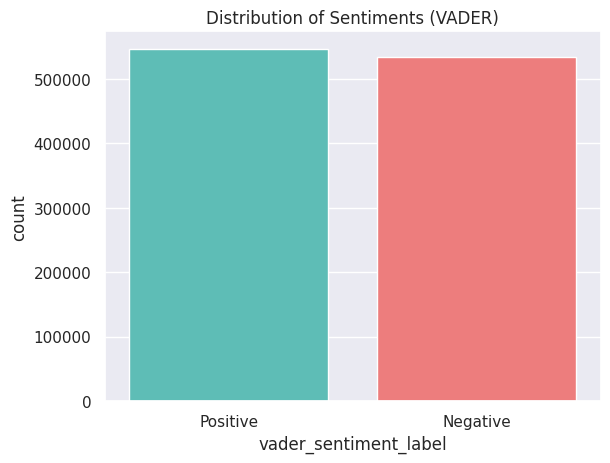

In [ ]:
sns.countplot(data=merged_df, x='vader_sentiment_label', hue='vader_sentiment_label',
              order=['Positive', 'Negative'], palette=["#4ECDC4", "#FF6B6B"], legend=False)
plt.title("Distribution of Sentiments (VADER)")
plt.show()

**TextBlob Sentiment Distribution**:
   - Similarly, a **countplot** is created for sentiment labels classified by TextBlob.
   - The same color palette and structure are applied to maintain consistency across both visualizations.
   - The plot is titled *"Distribution of Sentiments (TextBlob)"*.

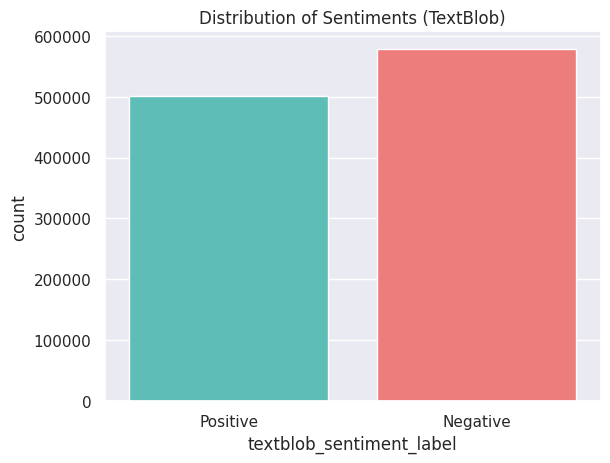

In [ ]:
sns.countplot(data=merged_df, x='textblob_sentiment_label', hue='textblob_sentiment_label',
              order=['Positive', 'Negative'], palette=["#4ECDC4", "#FF6B6B"], legend=False)
plt.title("Distribution of Sentiments (TextBlob)")
plt.show()

### Observations
- These visualizations provide a quick and intuitive understanding of the proportion of **Positive** and **Negative** comments detected by each sentiment analysis method.
- Differences in sentiment classification between VADER and TextBlob can be visually compared, highlighting the nuances of each method.

### Purpose
Visualizing sentiment distribution helps to:
- Summarize the overall tone of the dataset.
- Compare the performance and tendencies of VADER and TextBlob in classifying sentiment.
- Offer insights into the emotional engagement of users in the analyzed comments.

This step is crucial for understanding the sentiment trends before proceeding to further analyses or model-building tasks.

### Sentiment Analysis: Displaying Comments

Displaying the comments with their corresponding sentiment labels (**Positive** or **Negative**) and sentiment scores. It provides a direct way to examine specific examples of user comments based on sentiment classification.

**Function Overview**:
   - The function `print_comments_neatly` filters comments based on the specified sentiment label (`Positive` or `Negative`) from the `vader_sentiment_label` column.
   - It displays up to a predefined number of comments (`num_comments=5`) along with their sentiment scores.

In [ ]:
def print_comments_neatly(df, sentiment_label, num_comments=5):
    print(f"\n{'='*20} {sentiment_label.upper()} COMMENTS {'='*20}")
    filtered_df = df[df['vader_sentiment_label'] == sentiment_label]
    for i, row in enumerate(filtered_df.itertuples(), 1):
        print(f"{i}. Comment: {row.comment}")
        print(f"   Sentiment Score: {row.vader_sentiment:.2f}")
        print("-" * 60)
        if i >= num_comments:
            break

print_comments_neatly(merged_df, sentiment_label='Positive', num_comments=5)

print_comments_neatly(merged_df, sentiment_label='Negative', num_comments=5)


==================== POSITIVE COMMENTS ====================
1. Comment: big boobs lmao
   Sentiment Score: 0.60
------------------------------------------------------------
2. Comment: This will work for a specific type of woman, one that prioritizes emotions over values. The real question is how to find women that prioritize values over emotions because those types of women are a good match for a long term relationship.
   Sentiment Score: 0.81
------------------------------------------------------------
3. Comment: God of the Dates 🤍
   Sentiment Score: 0.27
------------------------------------------------------------
4. Comment: I am getting 300+ likes on bumble every month. And this all matches from new York.. 
But I am living in Asia and looking for serious marriage but dont know nothing workout from 2-3 months
   Sentiment Score: 0.12
------------------------------------------------------------
5. Comment: Bro this thumbnail text looks like "How to 3 star a town hall 11 base ful

**Example Output**:
   - **Positive Comments**: Contains optimistic or agreeable comments, such as:
     ```text
     1. Comment: big boobs lmao
        Sentiment Score: 0.60
     ...
     5. Comment: Bro this thumbnail text looks like "How to 3 star a town hall 11 base full guide"😭 its not that hard guys rlyy,be natural
        Sentiment Score: 0.30
     ```
   - **Negative Comments**: Contains critical or skeptical comments, such as:
     ```text
     1. Comment: Can you do a video on what to do if you encounter her boyfriend and how to de-escalate the situation...
        Sentiment Score: 0.00
     ...
     5. Comment: Dating is mostly physical attractiveness problem. What do you do if your ugly or too old? Pay and be a simp and get used?
        Sentiment Score: -0.61
     ```

### Missing Nuances in Sentiment Classification

While this method captures the general tone of comments, it misses important nuances in the text:

 **Contextual Sentiment**:
   - Some comments classified as **Positive** or **Negative** might contain mixed emotions or sarcasm, which basic sentiment analysis tools struggle to identify.
   - For example:
     - **Positive**: "Bro this thumbnail text looks like 'How to 3 star a town hall 11 base full guide'😭 its not that hard guys rlyy, be natural" – While humorous, the sentiment score doesn't fully capture the sarcastic tone.
     - **Negative**: "Can you do a video on what to do if you encounter her boyfriend...?" – This comment is neutral or actionable but scored as **Negative**.

 **Neutral Comments Misclassified**:
   - Comments with a sentiment score close to `0` are often misclassified as **Positive** or **Negative**. For example:
     - "people still watch this kind of videos in 2025?" – This has a score of `0.00` but is subjective and could be interpreted as neutral or skeptical.

 **Length and Complexity**:
   - Long comments with detailed explanations often contain multiple sentiments. For instance:
     - "About cold approaches, it's just not true... Do I do something wrong judging by my conversions? Absolutely..." – This mixes criticism, self-reflection, and suggestions, making it hard to label as purely **Negative**.

 **Cultural and Contextual Factors**:
   - Comments like "big boobs lmao" or "God of the Dates 🤍" are classified as **Positive**, but their actual sentiment depends on cultural or contextual understanding, which simple sentiment scoring tools cannot address.

### Limitations and Next Steps

- **Nuance Detection**: To improve accuracy, more advanced sentiment analysis tools (e.g., BERT-based models) or human validation might be required to capture sarcasm, mixed emotions, and context.
- **Neutral Category**: Adding a **Neutral** label for comments with sentiment scores close to `0` could reduce misclassification.
- **Topic Analysis**: Combining sentiment analysis with topic modeling could provide deeper insights into the themes and emotional tones of the comments.

This section highlights the strengths of automated sentiment analysis while acknowledging its limitations in capturing the full complexity of human emotions and language.

### Dropping TextBlob and keeping VADER

We initially explored TextBlob for sentiment analysis due to its simplicity and effectiveness for general text. However, we switched to VADER as it is specifically designed for analyzing short, informal text, such as social media comments. VADER's ability to handle slang, emojis, and negations, combined with its speed and accuracy, made it a better fit for this project.

### Distribution of VADER Sentiment Scores

This plot visualizes the distribution of VADER sentiment scores across the dataset. It provides insights into how the sentiment of comments is distributed and helps identify trends or patterns in emotional tone.

 **Histogram**:
   - Displays the frequency of sentiment scores grouped into 30 bins.
   - The x-axis represents the sentiment scores, ranging from -1 (very negative) to +1 (very positive).
   - The y-axis shows the frequency of comments for each range of sentiment scores.

 **Kernel Density Estimate (KDE)**:
   - Overlays a smoothed curve to represent the distribution density.
   - Helps better visualize the central tendency and spread of the data.

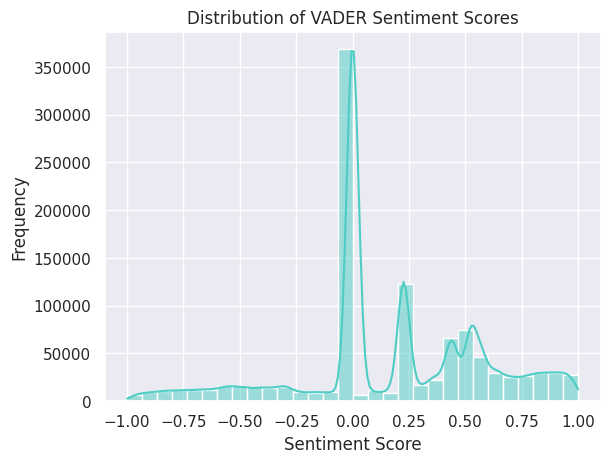

In [ ]:
sns.histplot(merged_df['vader_sentiment'], bins=30, kde=True, color='#4ECDC4')
plt.title('Distribution of VADER Sentiment Scores')
plt.xlabel('Sentiment Score')
plt.ylabel('Frequency')
plt.show()

### Descriptive Statistics

| Metric            | Value         |
|--------------------|---------------|
| **Count**         | 1,079,836     |
| **Mean**          | 0.1736        |
| **Standard Deviation** | 0.4213    |
| **Minimum**       | -0.9998       |
| **25th Percentile** | 0.0000      |
| **Median (50%)**  | 0.0557        |
| **75th Percentile** | 0.5264      |
| **Maximum**       | 1.0000        |

#### Key Takeaways:
 **Mean Sentiment Score**: The average sentiment score is **0.1736**, indicating a slight positive bias in the dataset.
 **Median**: The median score is **0.0557**, showing that the majority of scores cluster near neutral but lean slightly positive.
 **Range**:
   - The minimum score is **-0.9998**, representing the most negative sentiment.
   - The maximum score is **1.0000**, representing the most positive sentiment.
 **Spread**:
   - The standard deviation of **0.4213** indicates a moderate spread in sentiment scores.



### Frequency Distribution (Binned)

The histogram groups sentiment scores into 30 bins, revealing the frequency of scores across ranges. Here are some notable findings:

- **Most Frequent Range**: The range **(-0.0666, 0.0001]** has the highest count (**368,397 comments**), indicating a prevalence of comments with near-neutral or slightly negative sentiment.
- **Positive Sentiment Distribution**:
  - Scores between **(0.2, 0.267]** (123,058 comments) and **(0.467, 0.533]** (74,387 comments) are the most frequent among positive sentiments.
  - Higher positive scores, such as **(0.933, 1.0]**, are less frequent but still significant, with **27,264 comments** in this range.
- **Negative Sentiment Distribution**:
  - Negative scores, such as **(-0.6, -0.533]** (16,249 comments) and **(-0.533, -0.467]** (15,561 comments), are less frequent than positive scores.
  - Extremely negative scores, such as **(-1.002, -0.933]**, occur rarely (**6,627 comments**).

### Raw Sentiment Scores (First 10)

| Index | Sentiment Score |
|-------|-----------------|
| 0     | 0.5994          |
| 1     | 0.8074          |
| 2     | 0.0000          |
| 3     | 0.2732          |
| 4     | -0.1050         |
| 5     | -0.5967         |
| 6     | 0.0000          |
| 7     | 0.1154          |
| 8     | 0.2951          |
| 9     | 0.3896          |

#### Observations:
- The first 10 scores range from **-0.5967** (negative) to **0.8074** (positive).
- Neutral scores like **0.0000** appear frequently, reflecting a mix of comments with no strong sentiment.


### Insights from the Plot and Data

 **Neutral Bias**:
   - A large number of comments are clustered near 0, indicating a significant portion of the dataset has a neutral or mixed sentiment.

 **Positive Skew**:
   - The mean and median both lean slightly positive, suggesting the dataset contains more positive comments than negative ones.

 **Long Tail of Extreme Sentiments**:
   - Both highly positive (close to +1) and highly negative (close to -1) sentiments occur but are relatively rare.

 **Real-world Implications**:
   - The prevalence of neutral and slightly positive comments may reflect typical online behavior, where users often express mild opinions rather than extreme emotions.

This analysis provides a deeper understanding of the sentiment tendencies in the dataset and complements the visual representation in the plot.

## Scatter Plot: Sentiment Score vs. Comment Length

This scatter plot visualizes the relationship between **VADER sentiment scores** and **comment lengths**. It helps us understand how the length of a comment correlates with its sentiment.

### Key Features of the Plot
- **X-Axis (VADER Sentiment Score)**:
  - Represents the sentiment scores, ranging from -1 (very negative) to +1 (very positive).
- **Y-Axis (Comment Length)**:
  - Indicates the length of each comment, measured in the number of characters.
- **Color and Transparency**:
  - The points are colored purple with an alpha value of 0.5, providing better visibility for overlapping points.

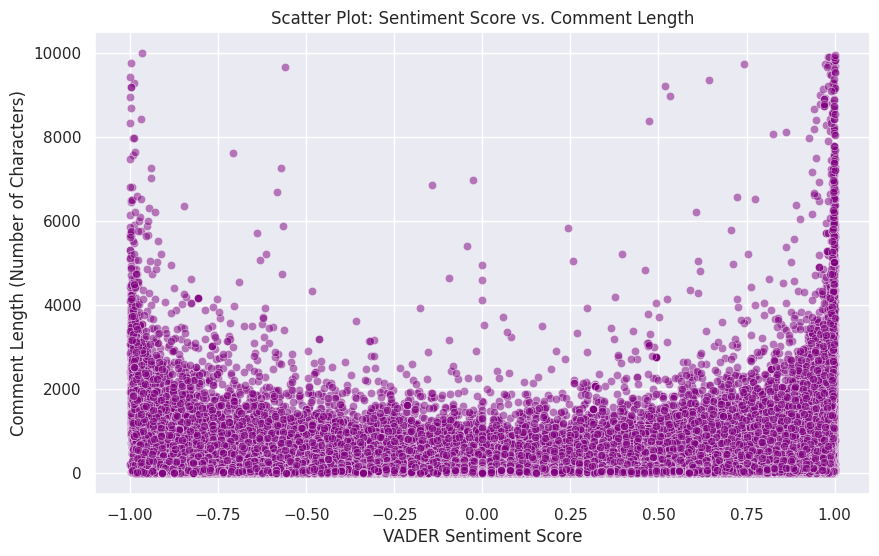

In [ ]:
merged_df['comment_length'] = merged_df['comment'].apply(lambda x: len(str(x)) if isinstance(x, str) else 0)

plt.figure(figsize=(10, 6))
sns.scatterplot(data=merged_df, x='vader_sentiment', y='comment_length', alpha=0.5, color='purple')
plt.title('Scatter Plot: Sentiment Score vs. Comment Length')
plt.xlabel('VADER Sentiment Score')
plt.ylabel('Comment Length (Number of Characters)')
plt.show()

### Numerical Data Summary

### First 10 Rows of Data:
| VADER Sentiment | Comment Length |
|-----------------|----------------|
| 0.5994          | 14             |
| 0.8074          | 239            |
| 0.0000          | 248            |
| 0.2732          | 18             |
| -0.1050         | 523            |
| -0.5967         | 90             |
| 0.0000          | 48             |
| 0.1154          | 187            |
| 0.2951          | 121            |
| 0.3896          | 651            |

### Descriptive Statistics:
| Metric                   | VADER Sentiment    | Comment Length       |
|---------------------------|--------------------|----------------------|
| **Count**                | 1,079,836          | 1,079,846            |
| **Mean**                 | 0.1736             | 114.58               |
| **Standard Deviation (std)** | 0.4213         | 255.87               |
| **Minimum (min)**        | -0.9998            | 0                    |
| **25th Percentile (25%)**| 0.0000             | 29.0                 |
| **Median (50%)**         | 0.0557             | 51.0                 |
| **75th Percentile (75%)**| 0.5264             | 104.0                |
| **Maximum (max)**        | 1.0000             | 9,992.0              |


### Insights from the Data and Plot

 **General Comment Length Trends**:
   - The average comment length is **114.58 characters**, with a wide range extending from **0** (empty comments) to **9,992 characters**.
   - The **median comment length** is only **51 characters**, indicating that most comments are relatively short.

 **Neutral and Mixed Sentiments**:
   - Sentiments near **0 (neutral)** are associated with a range of comment lengths, from very short to very long.
   - This suggests that neutral comments are common across various levels of detail and complexity.

 **Extreme Sentiments**:
   - Comments with extreme positive (**~1**) or extreme negative (**~-1**) sentiment scores tend to be shorter, as indicated by clustering at lower comment lengths.
   - This implies that highly emotional expressions are often brief and to the point.

 **Variability in Comment Length**:
   - The **standard deviation** of comment length (**255.87 characters**) highlights significant variability, with some comments being exceptionally detailed while others are very concise.

 **Outliers**:
   - The maximum comment length of **9,992 characters** is an outlier and represents unusually verbose comments, which might warrant further investigation.


### Why This Matters
The relationship between sentiment scores and comment lengths is important for understanding:
- **Behavioral Patterns**: Shorter comments often express more extreme emotions, while longer comments lean toward neutrality or mixed sentiment.
- **Content Analysis**: Knowing the typical length of comments can guide strategies for moderation, content curation, or summarization.

This analysis complements the scatter plot visualization by providing a quantitative breakdown of the data, helping to interpret the trends more effectively.

### Most Frequent Words in Highly Positive and Highly Negative Comments

This analysis identifies the most frequently used words in comments with **highly positive sentiment** (VADER Sentiment > 0.9) and **highly negative sentiment** (VADER Sentiment < -0.9). By visualizing and analyzing these words, we can gain insights into the common themes and language patterns in extreme sentiments.

#### `get_most_frequent_words` Function:
- **Purpose**: Extracts and counts the most frequent words in comments filtered by a sentiment condition.
- **Steps**:
   Filters comments in the `df` DataFrame based on the sentiment condition `sentiment_filter`.
   Joins all filtered comments into a single string and splits them into individual words.
   Cleans the list of words by removing stopwords (from `STOPWORDS`) and non-alphabetic terms.
   Counts the frequency of each word using `Counter` and retrieves the top `num_words` most common entries.
   Returns the results as a DataFrame with columns `Word` and `Frequency`.

#### Generating Positive Words Plot:
- Filters comments with **VADER Sentiment > 0.9** to identify words associated with highly positive comments.
- Creates a bar plot using `sns.barplot` to visualize the top 10 most frequent words and their respective frequencies.
- Uses a custom mint green color palette (`#4ECDC4`) for a visually appealing positive tone.

#### Generating Negative Words Plot:
- Filters comments with **VADER Sentiment < -0.9** to identify words associated with highly negative comments.
- Similarly, creates a bar plot for the top 10 most frequent negative words.
- Uses a custom coral red palette (`#FF6B6B`) to visually distinguish it as negative sentiment.


### Key Features of the Code

#### Sentiment Filtering:
- The function uses a lambda function (`lambda x: x > 0.9` or `lambda x: x < -0.9`) to dynamically filter comments based on sentiment thresholds.

#### Visualization:
- The use of Seaborn (`sns.barplot`) creates clean and professional bar plots.
- Hue is set to `Word` for compatibility with future Seaborn versions, and legends are manually removed for clarity.

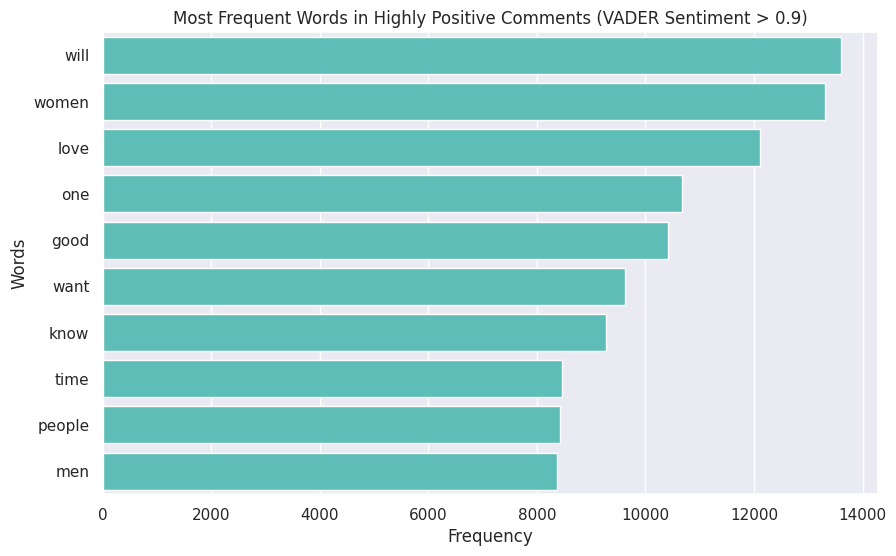

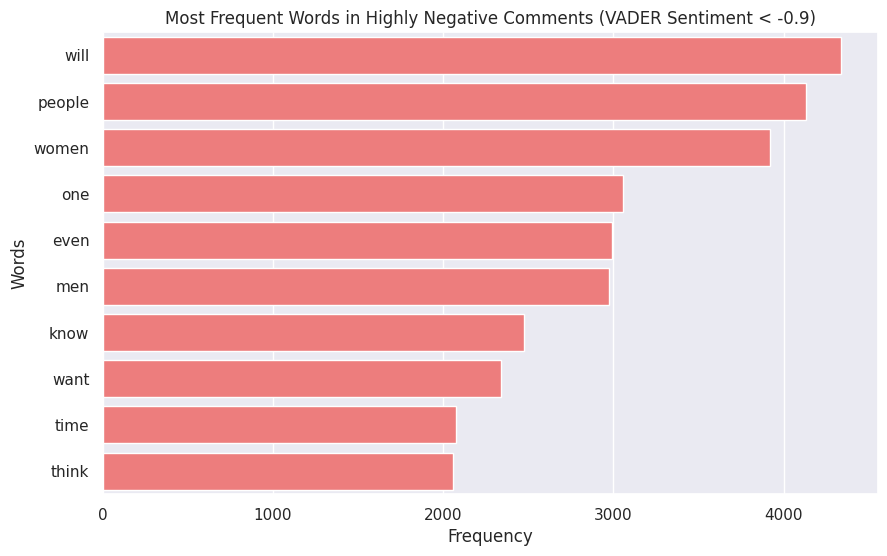

In [ ]:
def get_most_frequent_words(df, sentiment_filter, num_words=10):
    filtered_comments = df[df['vader_sentiment'].apply(sentiment_filter)]['comment']

    all_words = ' '.join(str(comment) for comment in filtered_comments).lower().split()
    cleaned_words = [word for word in all_words if word not in STOPWORDS and word.isalpha()]

    most_common_words = Counter(cleaned_words).most_common(num_words)
    return pd.DataFrame(most_common_words, columns=['Word', 'Frequency'])

positive_words_df = get_most_frequent_words(merged_df, sentiment_filter=lambda x: x > 0.9)

plt.figure(figsize=(10, 6))
sns.barplot(data=positive_words_df, x='Frequency', y='Word', hue='Word', dodge=False, palette=['#4ECDC4'] * len(positive_words_df))
plt.title('Most Frequent Words in Highly Positive Comments (VADER Sentiment > 0.9)')
plt.xlabel('Frequency')
plt.ylabel('Words')
plt.legend([],[], frameon=False)
plt.show()

negative_words_df = get_most_frequent_words(merged_df, sentiment_filter=lambda x: x < -0.9)

plt.figure(figsize=(10, 6))
sns.barplot(data=negative_words_df, x='Frequency', y='Word', hue='Word', dodge=False, palette=['#FF6B6B'] * len(negative_words_df))
plt.title('Most Frequent Words in Highly Negative Comments (VADER Sentiment < -0.9)')
plt.xlabel('Frequency')
plt.ylabel('Words')
plt.legend([],[], frameon=False)
plt.show()

### Highly Positive Comments (VADER Sentiment > 0.9)

#### Data Summary
| Rank | Word   | Frequency |
|------|--------|-----------|
| 1    | will   | 13,597    |
| 2    | women  | 13,299    |
| 3    | love   | 12,112    |
| 4    | one    | 10,664    |
| 5    | good   | 10,408    |
| 6    | want   | 9,623     |
| 7    | know   | 9,269     |
| 8    | time   | 8,458     |
| 9    | people | 8,419     |
| 10   | men    | 8,362     |

#### Observations
 **Positive Sentiment Indicators**:
   - Words like **"love"** and **"good"** highlight expressions of approval, happiness, and appreciation.
   - These words align with the overall positive tone of the comments.

 **Future-Oriented Language**:
   - The word **"will"** appears most frequently, suggesting that highly positive comments often express optimism or plans for the future.

 **Gender-Specific Mentions**:
   - Words like **"women"** and **"men"** frequently appear, indicating that gender-related topics are prominent in positively expressed themes.

 **Action-Oriented Words**:
   - Words such as **"want"** and **"know"** suggest that positive comments often describe desires, intentions, or knowledge-sharing.

### Highly Negative Comments (VADER Sentiment < -0.9)

#### Data Summary
| Rank | Word    | Frequency |
|------|---------|-----------|
| 1    | will    | 4,335     |
| 2    | people  | 4,133     |
| 3    | women   | 3,919     |
| 4    | one     | 3,056     |
| 5    | even    | 2,991     |
| 6    | men     | 2,973     |
| 7    | know    | 2,475     |
| 8    | want    | 2,337     |
| 9    | time    | 2,078     |
| 10   | think   | 2,055     |

### Observations
 **Critical and Skeptical Tone**:
   - Words like **"even"** and **"think"** suggest a tone of doubt or criticism in highly negative comments.

 **Common Topics Across Sentiments**:
   - Words such as **"people"**, **"women"**, and **"men"** appear in both positive and negative comments, indicating that discussions about gender and societal topics are emotionally charged in both directions.

 **Future Language with a Negative Twist**:
   - The word **"will"** appears frequently, but in the context of negative comments, it might reflect pessimism or negative predictions.

 **Action and Emotion**:
   - Words like **"want"** and **"know"** may indicate dissatisfaction or frustration, where people express unmet desires or negative reflections on knowledge.


### Comparison Between Positive and Negative Comments
 **Shared Words**:
   - Words like **"will"**, **"people"**, **"women"**, **"men"**, and **"know"** are prominent in both positive and negative comments, showing that the same topics can evoke both positive and negative emotions depending on the context.

 **Emotionally Distinct Words**:
   - Positive comments include words like **"love"** and **"good"**, emphasizing positivity and approval.
   - Negative comments introduce words like **"even"** and **"think"**, which convey skepticism and criticism.

 **Frequency Gap**:
   - Positive words tend to appear more frequently overall, which could indicate that highly positive comments are generally longer or contain more repetitive expressions.


### Why This Matters
By identifying the most frequent words in highly positive and negative comments, we can better understand the themes and topics that drive emotional responses in user comments. This insight can be applied to:
- **Content Moderation**: Identifying emotionally charged topics that may require closer attention.
- **User Engagement**: Tailoring responses or content to address common themes.
- **Sentiment Analysis Models**: Refining models to better capture the nuances of extreme sentiments.

These findings highlight the power of simple word frequency analysis in uncovering meaningful patterns within text data.

---
# Topic Modeling

Topic modeling is a technique used to automatically identify themes or topics within a collection of text documents. It helps uncover the underlying structure of large text datasets by grouping similar words together into topics. Each document in the dataset can then be represented as a mixture of these topics, allowing us to understand the key themes present.

This method is particularly useful when working with large collections of unstructured text, such as customer feedback, social media comments, or articles. By applying topic modeling, we can gain insights into the most discussed themes, identify trends, and organize text data in a meaningful way.

In the following section, we will explore how to perform topic modeling programmatically, using code to extract and visualize topics from text data.

We will use various tools to preprocess text data, extract patterns, and uncover underlying topics. Libraries like **NLTK** and **SpaCy** will help in cleaning and preparing text, while **Gensim** and **Scikit-learn** will be used to apply advanced topic modeling algorithms such as Latent Dirichlet Allocation (LDA) and Non-negative Matrix Factorization (NMF). Finally, we’ll utilize **pyLDAvis** for interactive visualization of the discovered topics, making it easier to interpret and analyze the results.

## Text Preprocessing

Before performing topic modeling, it is important to preprocess the text data to ensure meaningful results. The following preprocessing steps were applied to each comment:

**Lowercasing:**  
   All text is converted to lowercase to ensure that words like "The" and "the" are treated as the same word.

 **Removing Non-Alphabetic Characters:**  
   Punctuation, numbers, and special characters are removed, leaving only alphabetic characters and whitespace.

 **Tokenization:**  
   The text is split into individual words (tokens) for easier processing.

 **Stopword Removal:**  
   Common English words that do not contribute significant meaning (such as "the", "and", "in") are removed using a standard stopword list.

 **Lemmatization:**  
   Words are reduced to their base or dictionary form (e.g., "running" becomes "run") to group similar words together.

 **Reassembly:**  
   The processed tokens are joined back together into a single string for each comment, ready for vectorization.


In [14]:
def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'[^a-z\s]', '', text)
    tokens = text.split()
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words]
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word) for word in tokens]
    return ' '.join(tokens)

This preprocessing routine helps to clean and standardize the text data, which improves the quality and coherence of the topics identified during modeling.

### Applying Preprocessing to Comments

After defining the preprocessing function, I applied it to all comments in the dataset. This creates a new column, `cleaned_comment`, containing the cleaned and standardized text for each comment. Preprocessing ensures that the text is ready for topic modeling by removing noise and reducing each comment to its most meaningful words.

In [15]:
merged_df['cleaned_comment'] = merged_df['comment'].dropna().astype(str).apply(preprocess_text)

The resulting `cleaned_comment` column will be used for further analysis and topic modeling.

## Topic Modeling

After preprocessing the comments, I performed topic modeling using Latent Dirichlet Allocation (LDA). Topic modeling is an unsupervised machine learning technique that discovers hidden thematic structures in large collections of text. In this case, the goal was to automatically identify the main subjects discussed across all comments.

The process involved:
 **Vectorizing the cleaned text** using `CountVectorizer`, which transforms the text into a document-term matrix suitable for modeling.
 **Applying LDA**, which finds groups of words (topics) that frequently occur together and assigns each comment a mixture of these topics.
 **Extracting the top words** for each topic, which help interpret the meaning of the topics.

### Top Words Per Topic

Below are the top 10 words for each topic identified by the model. These keywords provide insight into the main themes present in the dataset:

| Topic | Top 10 Words |
|-------|--------------|
| **1** | told, place, warm, zeus, thank, corey, thanks, coach, video, great |
| **2** | close, punani, myron, fresh, red, lol, lmao, podcast, pill, episode |
| **3** | woman, like, im, dont, guy, time, girl, want, man, know |
| **4** | biden, joe, richest, nutritious, right, guy, topic, wonderful, particular, deepened |
| **5** | peterson, woman, jordan, people, hope, men, god, like, dont, life |


**How to interpret:**  
- Each topic is represented by a set of words that frequently appear together in the comments.
- For example, Topic 3 includes words like "woman", "like", "im", "dont", "guy", "girl", "man", which might indicate discussions or debates about gender or relationships.
- Topic 4, with words like "biden", "joe", "right", "topic", appears to relate to political discussions.
- Some topics contain names (e.g., "peterson", "jordan", "myron", "corey"), which may refer to prominent individuals or hosts mentioned in the comments.

In [17]:
def perform_topic_modeling(df, num_topics=5, num_words=10):
    comments = df['cleaned_comment'].dropna().astype(str)

    vectorizer = CountVectorizer(stop_words='english', max_features=5000)
    dtm = vectorizer.fit_transform(comments)

    lda = LatentDirichletAllocation(n_components=num_topics, random_state=42)
    lda.fit(dtm)

    topics = []
    feature_names = vectorizer.get_feature_names_out()
    for topic_idx, topic in enumerate(lda.components_):
        top_words = [feature_names[i] for i in topic.argsort()[-num_words:][::-1]]
        topics.append(f"Topic {topic_idx + 1}: " + ", ".join(top_words))

    return lda, dtm, vectorizer, topics

lda_model, dtm, vectorizer, topic_descriptions = perform_topic_modeling(merged_df, num_topics=5, num_words=10)

for topic in topic_descriptions:
    print(topic)

pyLDAvis.enable_notebook()

lda_vis = pyLDAvis.prepare(topic_term_dists=lda_model.components_,
                           doc_topic_dists=lda_model.transform(dtm),
                           doc_lengths=dtm.sum(axis=1).A1,
                           vocab=vectorizer.get_feature_names_out(),
                           term_frequency=np.asarray(dtm.sum(axis=0)).ravel())

pyLDAvis.display(lda_vis)

Topic 1: told, place, warm, zeus, thank, corey, thanks, coach, video, great
Topic 2: close, punani, myron, fresh, red, lol, lmao, podcast, pill, episode
Topic 3: woman, like, im, dont, guy, time, girl, want, man, know
Topic 4: biden, joe, richest, nutritious, right, guy, topic, wonderful, particular, deepened
Topic 5: peterson, woman, jordan, people, hope, men, god, like, dont, life


To further explore and interpret the topics, I used [pyLDAvis](https://pyldavis.readthedocs.io/), an interactive visualization library for LDA models. This tool allows us to:
- See how distinct or overlapping the topics are.
- Explore the most relevant words for each topic.
- Analyze the distribution of topics across the corpus.

*Above is an interactive visualization generated by pyLDAvis. You can hover over each topic to see its most relevant words and their relative importance.*

**In summary:**  
Topic modeling has helped uncover the main themes in the comment data, making it easier to understand what people are discussing most frequently and setting the stage for further analysis.

### Exploring Topic Modeling Data Points

In [ ]:
doc_topic_matrix = lda_model.transform(dtm)
print(doc_topic_matrix)

[[0.05000018 0.34492875 0.50436654 0.05000015 0.05070437]
 [0.01052632 0.01052788 0.95753692 0.01052632 0.01088256]
 [0.01178568 0.01195083 0.95262627 0.01176472 0.01187251]
 ...
 [0.2        0.2        0.2        0.2        0.2       ]
 [0.03333335 0.03336001 0.03380084 0.03333335 0.86617244]
 [0.02857189 0.87959025 0.03123399 0.02857178 0.0320321 ]]


In [ ]:
topic_word_matrix = lda_model.components_
print(topic_word_matrix)

[[2.00755602e-01 2.00363937e-01 2.00584908e-01 ... 2.00382169e-01
  2.00512912e-01 3.84853396e+02]
 [6.79161957e+01 2.06819226e-01 2.00391354e-01 ... 2.00313741e-01
  9.05507421e+01 2.01009920e-01]
 [6.01134234e+01 2.94612872e+02 1.64116806e+01 ... 2.51198420e+02
  9.41360421e+01 5.44650672e-01]
 [2.00153808e-01 2.00076417e-01 2.00103003e-01 ... 2.00034782e-01
  2.00325835e-01 2.00095358e-01]
 [1.01569472e+02 1.37798685e+01 1.99987240e+02 ... 2.00849663e-01
  2.99123771e+01 2.00847851e-01]]


In [ ]:
doc_topic_df = pd.DataFrame(doc_topic_matrix, columns=[f"Topic {i+1}" for i in range(lda_model.n_components)])
print(doc_topic_df.head())

    Topic 1   Topic 2   Topic 3   Topic 4   Topic 5
0  0.050000  0.344929  0.504367  0.050000  0.050704
1  0.010526  0.010528  0.957537  0.010526  0.010883
2  0.011786  0.011951  0.952626  0.011765  0.011873
3  0.066734  0.066667  0.400507  0.066667  0.399426
4  0.005000  0.005004  0.828422  0.005017  0.156556


In [ ]:
feature_names = vectorizer.get_feature_names_out()
topic_word_df = pd.DataFrame(topic_word_matrix, columns=feature_names)
print(topic_word_df.head())

        aaron          ab     abandon   abandoned      ability         able  \
0    0.200756    0.200364    0.200585    0.200344     0.200397     0.200336   
1   67.916196    0.206819    0.200391    0.200404     0.200529     0.200810   
2   60.113423  294.612872   16.411681   47.862936    53.833820  2587.683295   
3    0.200154    0.200076    0.200103    0.200067     0.200086     0.200150   
4  101.569472   13.779868  199.987240  207.536249  1988.565167  3215.715409   

     abortion     abraham     absence     absolute  ...        youve  \
0    0.200263    0.200244    0.200321     0.208844  ...     0.208057   
1    0.200823    0.200220    0.200333     7.600395  ...     0.201115   
2    0.238065    0.200542   30.394490   363.639339  ...  2812.789252   
3    0.200163    0.200035    0.200192     0.200362  ...     0.200148   
4  646.160685  273.198958  210.004665  1264.351060  ...   650.601427   

            yr          yt         yup         zero         zeus         zone  \
0     0.200

After fitting the topic model, I printed several datapoints from the results to better understand how the model represents the text data. These included:

- **Top words for each topic:**  
  The most frequent and representative words for each topic, which provide insight into the main themes across the comments.

- **Document-topic distributions:**  
  For each comment, the model estimates the proportion of each topic present. This helps identify which comments are most strongly associated with which topics.

- **Raw topic modeling matrices:**  
  I also examined the raw numerical matrices generated by the model, such as:

    - The **document-topic matrix** (shown above).
    - The **topic-word matrix**, which shows for each topic (row) the weight assigned to each word in the vocabulary (columns).  

#### Reflections

Some of these datapoints (like the top words per topic and the document-topic distributions) are directly interpretable and useful for understanding the themes in the data. Others, such as the raw topic-word matrix, are more technical and may not provide immediate insights to a general audience. However, reviewing these outputs helped me verify that the topic modeling process worked correctly and gave me a deeper understanding of how the model represents the data.

### Topic Modeling Results Summary

Below is a table showing the top words for each topic, helping to interpret what each topic represents:

In [ ]:
def display_topics_table(lda_model, vectorizer, num_words=10):
    feature_names = vectorizer.get_feature_names_out()
    topic_dict = {}
    for topic_idx, topic in enumerate(lda_model.components_):
        top_words = [feature_names[i] for i in topic.argsort()[-num_words:][::-1]]
        topic_dict[f"Topic {topic_idx + 1}"] = top_words
    topics_df = pd.DataFrame(topic_dict)
    print(topics_df)
    return topics_df

topics_df = display_topics_table(lda_model, vectorizer, num_words=10)

  Topic 1  Topic 2 Topic 3     Topic 4   Topic 5
0    told    close   woman       biden  peterson
1   place   punani    like         joe     woman
2    warm    myron      im     richest    jordan
3    zeus    fresh    dont  nutritious    people
4   thank      red     guy       right      hope
5   corey      lol    time         guy       men
6  thanks     lmao    girl       topic       god
7   coach  podcast    want   wonderful      like
8   video     pill     man  particular      dont
9   great  episode    know    deepened      life


Additionally, the bar chart below shows how many comments are primarily associated with each topic. This helps visualize which topics are most prevalent in the dataset:

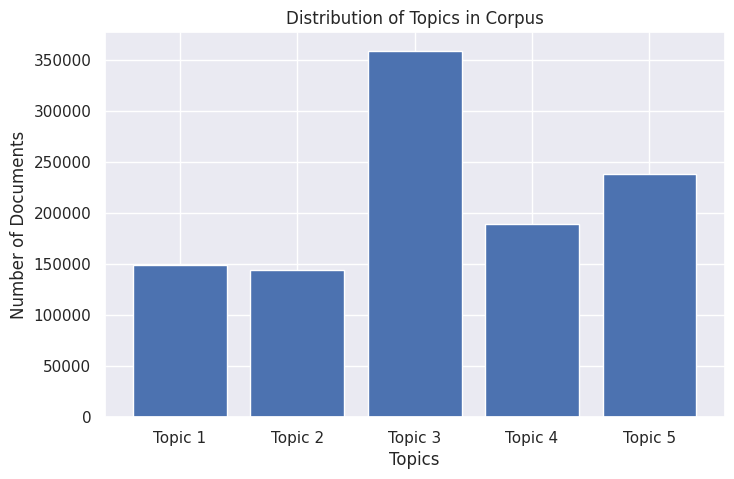

In [ ]:
doc_topic_matrix = lda_model.transform(dtm)
topic_counts = np.argmax(doc_topic_matrix, axis=1)
topic_distribution = pd.Series(topic_counts).value_counts().sort_index()

plt.figure(figsize=(8,5))
plt.bar([f"Topic {i+1}" for i in topic_distribution.index], topic_distribution.values)
plt.xlabel("Topics")
plt.ylabel("Number of Documents")
plt.title("Distribution of Topics in Corpus")
plt.show()

These outputs together provide a clear overview of both the content and relative importance of each topic in the corpus.

---
## Predictive Modeling

After exploring the main themes in the comments using topic modeling, the next step is to apply predictive modeling to gain further insights from the data. Predictive modeling involves using machine learning algorithms to predict a target variable based on features extracted from the data.

### Goals of Predictive Modeling

The specific goal of predictive modeling depends on the nature of the target variable. Common predictive modeling tasks include:
- **Classification:** Predicting a discrete label (e.g., sentiment: positive/negative, spam/not spam, topic category, etc.).
- **Regression:** Predicting a continuous value (e.g., rating score, number of likes, etc.).

### Steps Typically Involved

 **Defining the Target Variable:**  
   Decide what you want to predict (e.g., sentiment, topic, or any other label present in your dataset).

 **Feature Engineering:**  
   Extract features from the text data (e.g., using vectorized text, topic proportions from LDA, etc.).  
   You can use the document-topic matrix from your topic modeling as features, or the original text vectorization.

 **Splitting the Data:**  
   Divide your data into training and testing sets to evaluate model performance.

 **Model Selection and Training:**  
   Choose a suitable machine learning model (e.g., Logistic Regression, Random Forest, SVM) and train it on your features.

 **Evaluation:**  
   Assess the model’s performance using appropriate metrics (accuracy, precision, recall, F1-score for classification; RMSE or MAE for regression).

 **Interpretation:**  
   Analyze the results to understand which features are most important and how well the model predicts the target variable.

## Predictive Modeling: Sentiment Prediction

After exploring the main themes in the comments using topic modeling, the next analytical step is to predict the **sentiment** of each comment. Sentiment prediction aims to classify comments as positive, negative, or neutral, providing valuable insights into overall community attitudes and emotional tone.

### Why Sentiment Prediction?

- **Understand user attitudes:** Assess how users feel about various topics or events discussed.
- **Actionable insights:** Identify areas with positive feedback or negative sentiment for targeted actions.
- **Track changes over time:** Monitor shifts in sentiment around specific topics or during certain time periods.

### Predictive Modeling Workflow

**Defining the Target Variable:**  
   Decide what you want to predict—in this case, sentiment (positive, negative, or neutral). If sentiment labels are not present, they can be generated using a sentiment analysis tool such as VADER or TextBlob.

 **Feature Engineering:**  
   Extract features from the text data, such as:
   - The document-topic matrix from LDA (topic proportions for each comment).
   - Text vectorizations (e.g., TF-IDF, bag-of-words).
   - Other features (e.g., comment length).

 **Splitting the Data:**  
   Divide your data into training and testing sets to evaluate model performance.

 **Model Selection and Training:**  
   Choose a suitable machine learning model (e.g., Logistic Regression, Random Forest, SVM) and train it on your features.

 **Evaluation:**  
   Assess the model’s performance using appropriate metrics (e.g., accuracy, precision, recall, F1-score for classification tasks).

 **Interpretation:**  
   Analyze the results to understand which features are most important and how well the model predicts the target variable.


## Sentiment Prediction Results

After assigning sentiment labels to each comment using VADER and TextBlob, we evaluated the distribution of sentiment and the agreement between the two tools.

In [18]:
print("VADER label counts:\n", merged_df['vader_sentiment_label'].value_counts())
print("TextBlob label counts:\n", merged_df['textblob_sentiment_label'].value_counts())

agreement = (merged_df['vader_sentiment_label'] == merged_df['textblob_sentiment_label']).mean()
print(f"Agreement between VADER and TextBlob: {agreement:.2%}")

VADER label counts:
 vader_sentiment_label
Positive    545969
Negative    533877
Name: count, dtype: int64
TextBlob label counts:
 textblob_sentiment_label
Negative    578340
Positive    501506
Name: count, dtype: int64
Agreement between VADER and TextBlob: 80.67%


### Sentiment Label Distribution

The sentiment label counts for each tool were as follows:

- **VADER:**
  - Positive: 545,969 comments
  - Negative: 533,877 comments

- **TextBlob:**
  - Positive: 501,506 comments
  - Negative: 578,340 comments

Both tools produced a relatively even split between positive and negative sentiment, with VADER labeling slightly more comments as positive, while TextBlob was more likely to assign a negative label.

### Agreement Between Tools

To assess consistency, we calculated the proportion of comments where both VADER and TextBlob assigned the same sentiment label. The agreement rate was:

- **Agreement between VADER and TextBlob:** 80.67%

This high level of agreement suggests that, despite differences in their underlying methodologies, VADER and TextBlob often concur when classifying the sentiment of YouTube comments.

### Interpretation

- The substantial agreement rate (over 80%) supports the reliability of automated sentiment labeling in the absence of ground-truth human annotation.
- However, the roughly 20% disagreement highlights that certain comments are interpreted differently by each tool, likely due to nuances in language, context, or model-specific sensitivities.
- For downstream predictive modeling (e.g., using LDA topic proportions or other engineered features to predict sentiment), either set of labels could be used as a proxy target variable, with awareness of these limitations.

## Predictive Modeling: Sentiment Prediction Using Topic Features

To predict the sentiment of YouTube comments, we leveraged the topics extracted from LDA as features. For each comment, the LDA model provided a topic distribution vector, which was used as the input (`X`) for sentiment classification.

In [19]:
doc_topic_matrix = lda_model.transform(dtm)

In [25]:
X = doc_topic_matrix

y_vader = merged_df.loc[comments_df.index, 'vader_sentiment_label'].reset_index(drop=True)
y_textblob = merged_df.loc[comments_df.index, 'textblob_sentiment_label'].reset_index(drop=True)

### Feature Construction

- **Document-Topic Matrix:**  
  Each comment was represented as a vector of topic proportions using `lda_model.transform(dtm)`. This matrix (`X`) captures the relevance of each topic to every comment.
- **Target Variable:**  
  Sentiment labels were generated using two automated tools:
    - `y_vader`: Sentiment assigned by VADER
    - `y_textblob`: Sentiment assigned by TextBlob

Since no ground-truth sentiment labels were available, the model was trained to predict the sentiment labels provided by these tools, treating them as proxy targets.

### Aligning Features and Sentiment Labels

When preparing the data for predictive modeling, it is essential that the feature matrix (`X`) and the target sentiment labels (`y_vader`, `y_textblob`) have exactly matching indices and shapes. During preprocessing, a shape mismatch was detected:

- `X` (document-topic matrix) had shape `(1,079,836, 5)`.
- Both `y_vader` and `y_textblob` initially had shape `(1,079,846,)`.

This discrepancy indicated that ten comments had sentiment labels but did not have corresponding topic vectors (likely due to preprocessing steps, filtering, or tokenization issues).

In [19]:
print(X.shape)
print(y_vader.shape)
print(y_textblob.shape)

(1079836, 5)
(1079846,)
(1079846,)


#### How the Issue Was Fixed

To ensure proper alignment:
- The indices of the comments used for topic modeling (`comments_df.index`) were compared to those in the merged dataframe (`merged_df.index`).
- The set difference identified the indices of comments present in the sentiment label set but missing from the feature set (`missing_indices`).
- These `missing_indices` were then dropped from `comments_df`, resulting in a filtered DataFrame (`filtered_comments_df`) that perfectly matched the shape and order of `X`.
- Sentiment labels for VADER and TextBlob were then re-extracted using the indices of `filtered_comments_df`, ensuring that `X`, `y_vader`, and `y_textblob` were all fully aligned and ready for modeling.

In [20]:
missing_indices = set(comments_df.index) - set(merged_df.index[:X.shape[0]])
print(missing_indices)

{1079840, 1079841, 1079842, 1079843, 1079844, 1079845, 1079836, 1079837, 1079838, 1079839}


In [21]:
missing_indices = {1079840, 1079841, 1079842, 1079843, 1079844, 1079845, 1079836, 1079837, 1079838, 1079839}

filtered_comments_df = comments_df.drop(missing_indices)

y_vader = merged_df.loc[filtered_comments_df.index, 'vader_sentiment_label']
y_textblob = merged_df.loc[filtered_comments_df.index, 'textblob_sentiment_label']

print(X.shape)
print(y_vader.shape)
print(y_textblob.shape)

(1079836, 5)
(1079836,)
(1079836,)


#### Why This Alignment Is Important

- **Model Integrity:** If the feature matrix and labels are misaligned, models may learn from the wrong data, leading to invalid results.
- **Reproducibility:** Ensuring that features and labels correspond row-by-row is a foundational step for any supervised learning task.
- **Error Prevention:** Catching and fixing shape mismatches at this stage prevents subtle bugs and misinterpretations during model training and evaluation.

By explicitly aligning features and sentiment labels, we guarantee the validity of subsequent predictive modeling and analysis.

## Predictive Modeling Results: Sentiment Classification

To assess the predictive power of topic model features for sentiment analysis, we trained a Logistic Regression classifier to predict sentiment labels generated by both VADER and TextBlob. The document-topic matrix from LDA was used as the feature set for all models.

### Experimental Setup

- **Features:** Document-topic proportions from LDA (`X`)
- **Targets:**  
  - `y_vader`: Sentiment labels from VADER  
  - `y_textblob`: Sentiment labels from TextBlob
- **Model:** Logistic Regression  
- **Evaluation:** 80/20 train/test split with stratification on sentiment labels for balanced class distribution


In [22]:
def run_sentiment_model(X, y, label_source):
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )
    clf = LogisticRegression(max_iter=1000, random_state=42)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(f"\nResults for {label_source}:")
    print(f"Accuracy: {accuracy_score(y_test, y_pred):.2%}")
    print("Classification Report:")
    print(classification_report(y_test, y_pred))
    print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
    return clf, X_test, y_test, y_pred

In [23]:
clf_vader, X_test_vader, y_test_vader, y_pred_vader = run_sentiment_model(X, y_vader, "VADER")
clf_textblob, X_test_textblob, y_test_textblob, y_pred_textblob = run_sentiment_model(X, y_textblob, "TextBlob")


Results for VADER:
Accuracy: 64.96%
Classification Report:
              precision    recall  f1-score   support

    Negative       0.70      0.51      0.59    106775
    Positive       0.62      0.78      0.69    109193

    accuracy                           0.65    215968
   macro avg       0.66      0.65      0.64    215968
weighted avg       0.66      0.65      0.64    215968

Confusion Matrix:
 [[54652 52123]
 [23543 85650]]

Results for TextBlob:
Accuracy: 64.19%
Classification Report:
              precision    recall  f1-score   support

    Negative       0.64      0.75      0.69    115667
    Positive       0.64      0.52      0.57    100301

    accuracy                           0.64    215968
   macro avg       0.64      0.63      0.63    215968
weighted avg       0.64      0.64      0.64    215968

Confusion Matrix:
 [[86903 28764]
 [48564 51737]]


### Results

#### **1. VADER-Based Sentiment Model**

- **Accuracy:** **64.96%**

**Classification Report:**

| Label     | Precision | Recall | F1-score | Support  |
|-----------|-----------|--------|----------|----------|
| Negative  |    0.70   |  0.51  |   0.59   | 106,775  |
| Positive  |    0.62   |  0.78  |   0.69   | 109,193  |

- **Macro avg F1-score:** 0.64

**Confusion Matrix:**

|              | Predicted Negative | Predicted Positive |
|--------------|-------------------|-------------------|
| Actual Neg   |      54,652       |      52,123       |
| Actual Pos   |      23,543       |      85,650       |


#### **2. TextBlob-Based Sentiment Model**

- **Accuracy:** **64.19%**

**Classification Report:**

| Label     | Precision | Recall | F1-score | Support  |
|-----------|-----------|--------|----------|----------|
| Negative  |    0.64   |  0.75  |   0.69   | 115,667  |
| Positive  |    0.64   |  0.52  |   0.57   | 100,301  |

- **Macro avg F1-score:** 0.63

**Confusion Matrix:**

|              | Predicted Negative | Predicted Positive |
|--------------|-------------------|-------------------|
| Actual Neg   |      86,903       |      28,764       |
| Actual Pos   |      48,564       |      51,737       |

### **Interpretation**

- **Predictive Power:**  
  The topic model features provide moderate predictive power for both sentiment labeling schemes, with accuracies around 64–65%.
- **VADER Model:**  
  Shows higher recall for the Positive class (0.78), indicating strong ability to identify positive sentiment, but lower recall for Negative (0.51).
- **TextBlob Model:**  
  Shows higher recall for Negative class (0.75) but lower for Positive (0.52), suggesting a tendency for the model to favor the Negative label when uncertain.
- **Class Imbalance:**  
  Both models show some imbalance in precision and recall between Positive and Negative, likely reflecting differences in the label distribution and how topic proportions relate to sentiment in this data.
- **Confusion Matrices:**  
  The confusion matrices reveal that both models frequently misclassify one sentiment as the other, especially for samples near the decision boundary.

**Conclusion:**  
Topic proportions from LDA capture informative patterns for sentiment prediction but are not sufficient for highly accurate sentiment classification. Combining topic features with additional textual or linguistic features may further improve performance.

## Visualization

### Confusion Matrices for Sentiment Prediction


To better understand the performance of the sentiment classification models, we visualized the confusion matrices for both the VADER-labeled and TextBlob-labeled models side by side.

**Figure:**  
Side-by-side heatmaps of the confusion matrices for the VADER and TextBlob sentiment models.

- **Left:** VADER sentiment model confusion matrix (green colormap)
- **Right:** TextBlob sentiment model confusion matrix (red colormap)

### What the Confusion Matrices Show

- **Diagonal elements** represent correct classifications (true negatives and true positives).
- **Off-diagonal elements** represent misclassifications (false positives and false negatives).
- The axes are labeled as *Actual* (true sentiment label) and *Predicted* (model’s prediction), with class labels “Negative” and “Positive”.

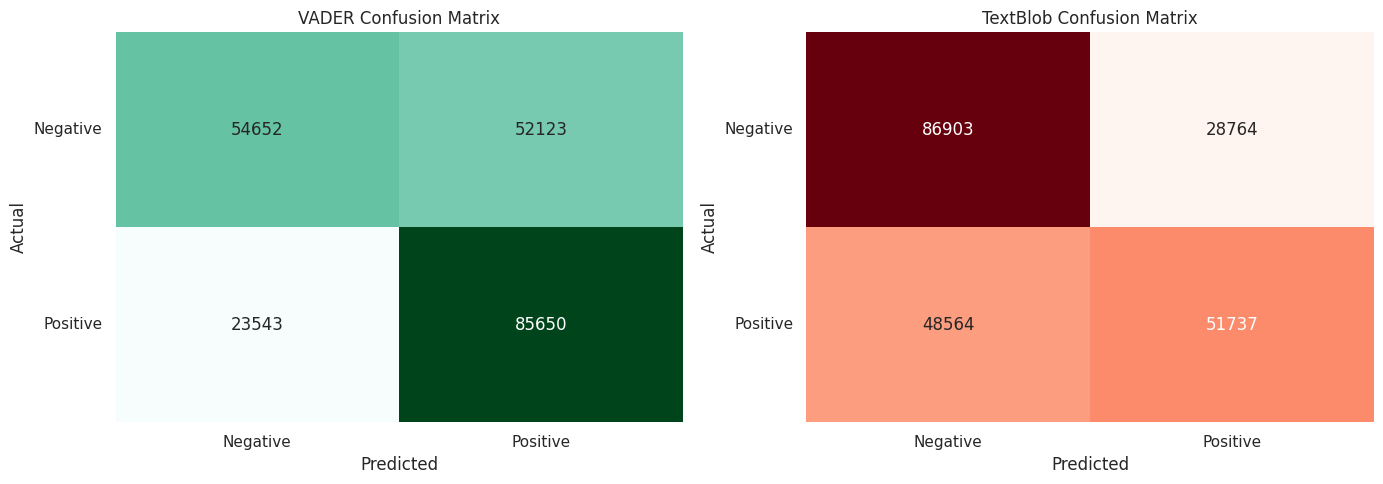

In [24]:
fig, axs = plt.subplots(1, 2, figsize=(14, 5))

sns.heatmap(confusion_matrix(y_test_vader, y_pred_vader), annot=True, fmt='d', cmap='BuGn', ax=axs[0], cbar=False)
axs[0].set_title('VADER Confusion Matrix')
axs[0].set_xlabel('Predicted')
axs[0].set_ylabel('Actual')
axs[0].set_xticklabels(['Negative', 'Positive'])
axs[0].set_yticklabels(['Negative', 'Positive'], rotation=0)

sns.heatmap(confusion_matrix(y_test_textblob, y_pred_textblob), annot=True, fmt='d', cmap='Reds', ax=axs[1], cbar=False)
axs[1].set_title('TextBlob Confusion Matrix')
axs[1].set_xlabel('Predicted')
axs[1].set_ylabel('Actual')
axs[1].set_xticklabels(['Negative', 'Positive'])
axs[1].set_yticklabels(['Negative', 'Positive'], rotation=0)

plt.tight_layout()
plt.show()

Below are the confusion matrices for the sentiment classification models trained on VADER and TextBlob labels, respectively. These matrices help visualize how well each model distinguished between positive and negative comments.

### VADER Sentiment Model

|                  | Predicted Negative | Predicted Positive |
|------------------|-------------------|-------------------|
| **Actual Negative** |      54,652        |      52,123        |
| **Actual Positive** |      23,543        |      85,650        |

- **True Negatives (54,652):** Negative comments correctly classified as negative.
- **False Positives (52,123):** Negative comments misclassified as positive.
- **False Negatives (23,543):** Positive comments misclassified as negative.
- **True Positives (85,650):** Positive comments correctly classified as positive.

**Insight:**  
The model is much better at correctly identifying positive comments (high true positive count), but has difficulty distinguishing some negative comments, resulting in a high false positive count. This aligns with the previously reported higher recall for the positive class.

### TextBlob Sentiment Model

|                  | Predicted Negative | Predicted Positive |
|------------------|-------------------|-------------------|
| **Actual Negative** |      86,903        |      28,764        |
| **Actual Positive** |      48,564        |      51,737        |

- **True Negatives (86,903):** Negative comments correctly classified as negative.
- **False Positives (28,764):** Negative comments misclassified as positive.
- **False Negatives (48,564):** Positive comments misclassified as negative.
- **True Positives (51,737):** Positive comments correctly classified as positive.

**Insight:**  
This model is more accurate in identifying negative comments (high true negative count), but tends to misclassify a notable number of positive comments as negative (high false negative count). This matches the higher recall for the negative class from the classification report.

### Overall Interpretation

- **Class Tendency:**  
  - The VADER model is more successful at predicting positive sentiment, but struggles with negative.
  - The TextBlob model is more successful at predicting negative sentiment, but struggles with positive.
- **Error Distribution:**  
  - Both models have a substantial number of misclassifications, suggesting that topic-based features alone may not fully capture the nuances of sentiment.
- **Practical Implication:**  
  - These matrices visually confirm the trade-offs identified in the classification reports, and highlight the impact of label source (VADER vs. TextBlob) on model performance.

## Classification Report: Precision, Recall, and F1-Score

The bar plots below summarize the precision, recall, and F1-score for each class (Negative, Positive) for both the VADER and TextBlob sentiment prediction models.

**Precision, recall, and F1-score** are important evaluation metrics for classification models:

- **Precision** measures how many of the items predicted as a certain class were actually correct. High precision means that when the model predicts a class, it is usually right.
- **Recall** measures how many of the actual items of a certain class the model was able to identify. High recall means the model successfully finds most of the relevant examples.
- **F1-score** is the harmonic mean of precision and recall. It provides a single score that balances both, and is especially useful when there is an uneven class distribution or when both false positives and false negatives are important.

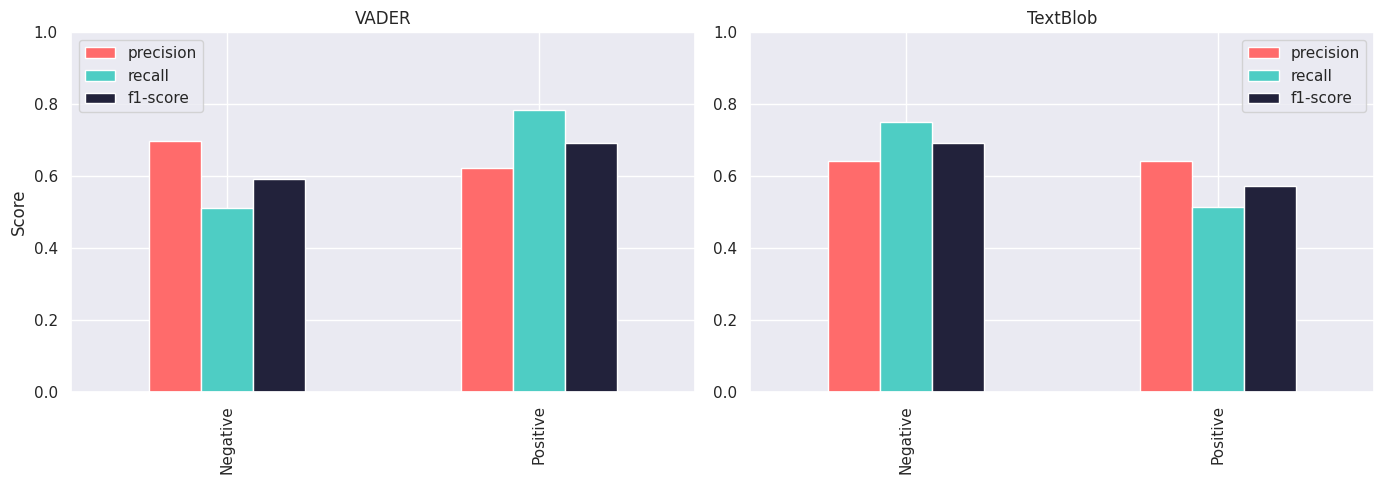

In [28]:
vader_report = classification_report(y_test_vader, y_pred_vader, output_dict=True)
textblob_report = classification_report(y_test_textblob, y_pred_textblob, output_dict=True)

vader_df = pd.DataFrame(vader_report).transpose().iloc[:-3, :]
textblob_df = pd.DataFrame(textblob_report).transpose().iloc[:-3, :]

custom_colors = ['#FF6B6B', '#4ECDC4', '#22223B']

fig, axs = plt.subplots(1, 2, figsize=(14, 5))

vader_df[['precision', 'recall', 'f1-score']].plot.bar(
    ax=axs[0],
    ylim=(0,1),
    title='VADER',
    color=custom_colors
)
axs[0].set_ylabel('Score')

textblob_df[['precision', 'recall', 'f1-score']].plot.bar(
    ax=axs[1],
    ylim=(0,1),
    title='TextBlob',
    color=custom_colors
)

plt.tight_layout()
plt.show()

- **Bar Chart:**  
  The visual plot makes it easy to compare the precision, recall, and F1-score for each class and model side-by-side.  
  - The VADER-based model is better at identifying positives.
  - The TextBlob-based model is better at identifying negatives.
- **Class Imbalance/Bias:**  
  Both models show a performance trade-off, likely influenced by the label distributions and the characteristics of each labeling tool.

### **Key Takeaways**
- **Topic features alone are not enough for highly accurate sentiment classification.**
- **Model performance is strongly dependent on the choice of sentiment labeler (VADER vs. TextBlob).**
- **The observed trade-offs reinforce the need for richer features or combined models for more balanced performance.**

## Predicted Sentiment Distribution

The bar plots and counts below illustrate the distribution of sentiment predictions made by each model on the test data:

- **VADER Model Predictions:**  
  - Negative: **78,195**  
  - Positive: **137,773**

- **TextBlob Model Predictions:**  
  - Negative: **135,467**  
  - Positive: **80,501**

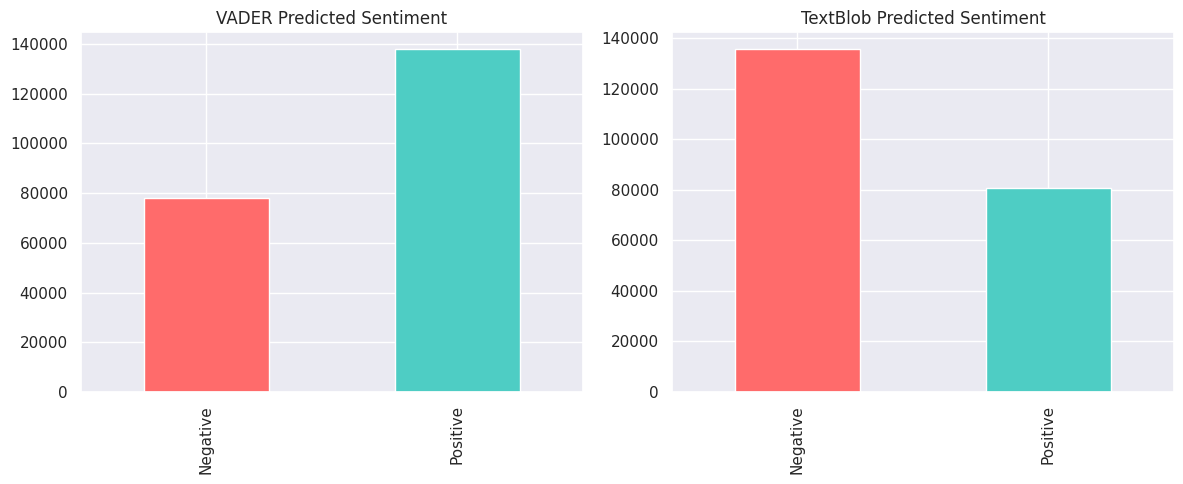

In [30]:
fig, axs = plt.subplots(1, 2, figsize=(12,5))

vader_counts = pd.Series(y_pred_vader).value_counts().sort_index()
textblob_counts = pd.Series(y_pred_textblob).value_counts().sort_index()

sentiment_palette = {'Negative': '#FF6B6B', 'Positive': '#4ECDC4'}

vader_colors = [sentiment_palette[label] for label in vader_counts.index]
vader_counts.plot(
    kind='bar',
    ax=axs[0],
    title='VADER Predicted Sentiment',
    color=vader_colors
)

textblob_colors = [sentiment_palette[label] for label in textblob_counts.index]
textblob_counts.plot(
    kind='bar',
    ax=axs[1],
    title='TextBlob Predicted Sentiment',
    color=textblob_colors
)

plt.tight_layout()
plt.show()

### Interpretation

- **VADER Model Bias:**  
  The VADER-based model predicts a much larger number of comments as positive than negative. This aligns with earlier findings that the model has higher recall for the positive class, meaning it is more likely to classify ambiguous or borderline cases as positive.

- **TextBlob Model Bias:**  
  In contrast, the TextBlob-based model predicts a much larger number of comments as negative. This matches the earlier observation of higher recall for the negative class, indicating a tendency to assign the negative label more frequently, especially when uncertain.

- **Labeler Influence:**  
  The stark difference in distribution highlights how the choice of sentiment labeler (VADER vs. TextBlob) significantly influences model behavior. Each model essentially inherits the bias of its labeler, resulting in markedly different sentiment landscapes.

- **Practical Implications:**  
  This bias impacts how sentiment analysis results might be interpreted in a real-world setting. Depending on the model used, an analyst could draw very different conclusions about the overall sentiment of the text data. It underscores the importance of validating models and, where possible, combining features or labelers for more balanced and reliable sentiment predictions.

## Actual vs. Predicted Sentiment Distribution

Below are the counts of actual and predicted sentiment labels for both the VADER- and TextBlob-based models:

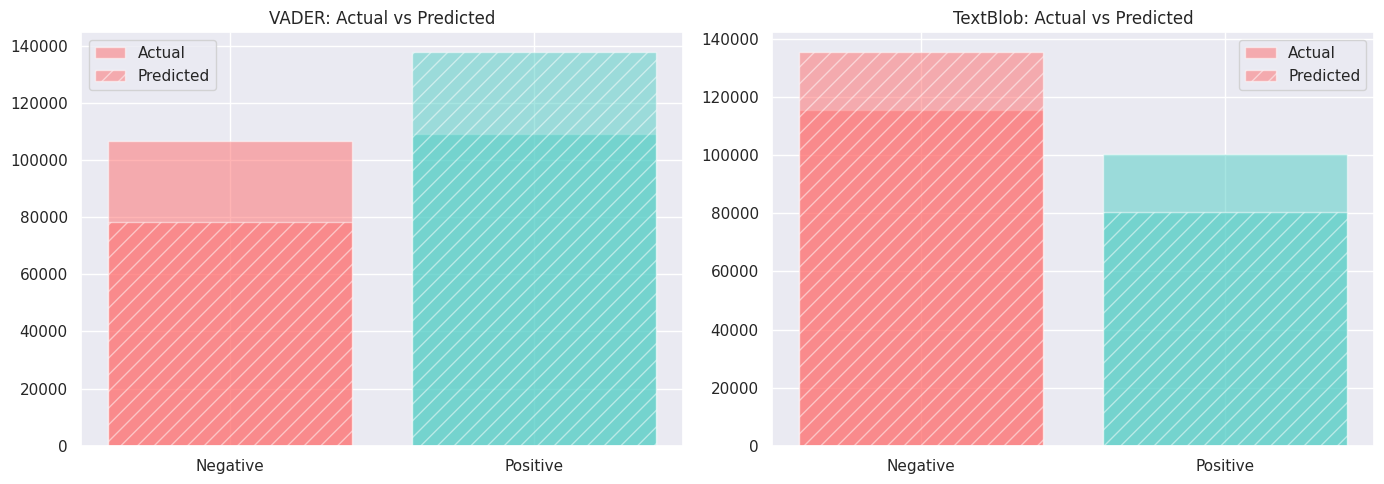

In [32]:
labels = sorted(y_test_vader.unique())
x = range(len(labels))

sentiment_palette = {'Negative': '#FF6B6B', 'Positive': '#4ECDC4'}
bar_colors = [sentiment_palette[label] for label in labels]

fig, axs = plt.subplots(1, 2, figsize=(14, 5))

axs[0].bar(x, pd.Series(y_test_vader).value_counts().sort_index(), alpha=0.5, label='Actual', color=bar_colors)
axs[0].bar(x, pd.Series(y_pred_vader).value_counts().sort_index(), alpha=0.5, label='Predicted', color=bar_colors, hatch='//')
axs[0].set_xticks(x)
axs[0].set_xticklabels(labels)
axs[0].set_title('VADER: Actual vs Predicted')
axs[0].legend()

axs[1].bar(x, pd.Series(y_test_textblob).value_counts().sort_index(), alpha=0.5, label='Actual', color=bar_colors)
axs[1].bar(x, pd.Series(y_pred_textblob).value_counts().sort_index(), alpha=0.5, label='Predicted', color=bar_colors, hatch='//')
axs[1].set_xticks(x)
axs[1].set_xticklabels(labels)
axs[1].set_title('TextBlob: Actual vs Predicted')
axs[1].legend()

plt.tight_layout()
plt.show()

### VADER Model

|                | Negative | Positive |
|----------------|----------|----------|
| **Actual**     | 106,775  | 109,193  |
| **Predicted**  | 78,195   | 137,773  |

- **Interpretation:**  
  - The actual sentiment distribution is almost balanced between negative and positive.
  - The VADER model, however, predicts far more positives (137,773) than negatives (78,195).
  - This suggests a **bias in the model toward predicting positive sentiment**—it tends to over-classify positive cases and under-classify negatives.
  - This observation aligns with the earlier confusion matrix and classification report, which showed higher recall for the positive class and lower recall for the negative class.


### TextBlob Model

|                | Negative | Positive |
|----------------|----------|----------|
| **Actual**     | 115,667  | 100,301  |
| **Predicted**  | 135,467  | 80,501   |

- **Interpretation:**  
  - The actual distribution is also relatively balanced, with a slight skew toward negative comments.
  - The TextBlob model predicts a much larger number of negatives (135,467) and fewer positives (80,501).
  - This indicates a **bias toward negative sentiment predictions**—the model over-classifies negatives and under-classifies positives.
  - This matches previous findings: higher recall for the negative class and lower recall for the positive class.


### Key Takeaways

- **Model Bias:**  
  Both models display a clear bias in their predictions:  
  - VADER leans positive,  
  - TextBlob leans negative.
- **Impact on Analysis:**  
  Such biases can significantly affect sentiment analysis outcomes, potentially skewing interpretations of the overall mood or opinion in your dataset.
- **Importance of Evaluation:**  
  Comparing actual vs. predicted distributions is crucial for understanding model tendencies and for choosing the right model depending on the application or for further calibration.


----
## Advanced NLP: Applying Modern Techniques for Sentiment and Emotion Analysis

In this section, we leverage advanced Natural Language Processing (NLP) techniques to move beyond simple rule-based sentiment labeling. Our goal is to classify sentiment, detect emotions, and extract deeper, nuanced insights from the text data.


## Sentiment Classification with Transformer Models

In recent years, transformer-based architectures have set new standards in natural language processing, delivering state-of-the-art results across a wide range of text analysis tasks. For this project, we harnessed the power of these models—specifically BERT and RoBERTa—to tackle the challenge of sentiment classification. By leveraging their ability to capture nuanced contextual information in text, we aimed to build a highly accurate classifier capable of discerning sentiment in domain-specific content.

### Approach

- **Model Selection:**  
  We selected pre-trained transformer models (e.g., BERT, RoBERTa) as the foundation for our sentiment classifier.

- **Fine-Tuning:**  
  The chosen model was fine-tuned on a labeled subset of our dataset. This process adapts the model to recognize domain-specific sentiment cues present in our data.

- **Implementation:**  
  Fine-tuning was carried out using the Hugging Face 🤗 Transformers library, with early stopping and validation splits to prevent overfitting. Data was tokenized and formatted according to the requirements of the pre-trained model.

### Data Preparation and Splitting

To prepare our dataset for sentiment classification, we first mapped the sentiment labels to numerical values. Specifically, we converted the `'vader_sentiment_label'` column into a new column called `'label'`, where `'Negative'` was mapped to `0` and `'Positive'` to `1`. This encoding is required for most machine learning models, which typically operate on numerical data.

We then extracted the cleaned text data and the corresponding sentiment labels into two lists:  
- `X` — containing the cleaned comments as strings  
- `y` — containing the numerical sentiment labels

To ensure robust evaluation and avoid data leakage, we split our data into training and test sets using an 80/20 ratio. We also used stratification based on the label to ensure that both sets maintained the same proportion of positive and negative samples as the original dataset. This helps the model generalize better and provides a more accurate measure of its real-world performance.

> **Note:**  
> During our initial experiments, we evaluated both TextBlob and VADER for sentiment labeling. After comparing their performance on our dataset, we found that VADER provided slightly better results, especially for capturing sentiment nuances in short, informal comments. As a result, we chose VADER as our primary sentiment labeling tool for this project and dropped TextBlob from the workflow.

In [21]:
label_column = 'vader_sentiment_label'

label_map = {'Negative': 0, 'Positive': 1}
merged_df['label'] = merged_df[label_column].map(label_map)

In [22]:
X = merged_df['cleaned_comment'].astype(str).tolist()
y = merged_df['label'].tolist()

train_texts, test_texts, train_labels, test_labels = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

This split ensures that all model training is performed only on the training set, while the test set remains unseen until final evaluation, providing an honest assessment of our model’s performance.

### Tokenization for BERT Input

Before feeding text data into a transformer model like BERT, it must be tokenized and formatted according to the model’s requirements. Tokenization is the process of converting text into tokens (numerical representations) that the model can understand.

In our workflow, we used the pre-trained `BertTokenizer` from the Hugging Face Transformers library. The tokenizer preprocesses our text data as follows:

- **Lowercasing and Splitting:**  
  The tokenizer converts all text to lowercase and splits sentences into subword tokens, in line with BERT’s “uncased” vocabulary.

- **Padding and Truncation:**  
  Each text sample is either padded (with special tokens) or truncated to a fixed length (`max_length=128`) to maintain uniform input size, which is required for efficient batch processing.

- **Conversion to Tensors:**  
  The output is returned as PyTorch tensors (`return_tensors='pt'`), allowing seamless integration with later model training steps.

We applied the tokenizer to both our training and test sets to ensure consistent preprocessing:

In [23]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

def tokenize_texts(texts):
    return tokenizer(
        texts,
        padding='max_length',
        truncation=True,
        max_length=128,
        return_tensors='pt'
    )

train_encodings = tokenize_texts(train_texts)
test_encodings = tokenize_texts(test_texts)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

This preparation step ensures that our model receives inputs in the format it expects, setting the stage for effective fine-tuning and evaluation.

### Creating a Custom Dataset and Initializing the Model

To train our BERT-based sentiment classifier with PyTorch, we created a custom dataset class that inherits from `torch.utils.data.Dataset`. This class takes care of storing the tokenized encodings and labels, and provides them in the format expected by the model during training and evaluation.

- **Initialization (`__init__`)**:  
  The constructor stores the encodings (tokenized inputs) and their corresponding sentiment labels.

- **Item Retrieval (`__getitem__`)**:  
  This method retrieves a single sample, preparing a dictionary of input tensors for the model. It also ensures that the label is converted into a PyTorch tensor and included under the key `'labels'`, as required by Hugging Face's Trainer and BERT models.

- **Length (`__len__`)**:  
  Returns the total number of samples in the dataset.

We then instantiated this custom dataset for both the training and test splits:

In [24]:
class SentimentDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels
    def __getitem__(self, idx):
        item = {key: val[idx] for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item
    def __len__(self):
        return len(self.labels)

train_dataset = SentimentDataset(train_encodings, train_labels)
test_dataset = SentimentDataset(test_encodings, test_labels)

We also initialized the BERT model for sequence classification, specifying `num_labels=2` for our binary sentiment task:

In [25]:
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


This setup ensures that our data pipeline and model are ready for fine-tuning on the sentiment classification task.

### Model Training and Evaluation Setup

To fine-tune our BERT-based sentiment classifier, we used Hugging Face's `Trainer` API, which simplifies the training and evaluation process for transformer models. The following steps outline our setup:

- **Training Arguments:**  
  We defined a set of training arguments using the `TrainingArguments` class. These include:
  - The directory to save model outputs (`output_dir='./results'`) and logs.
  - Training for 2 epochs (this can be increased with more time or resources).
  - Batch sizes for training and evaluation.
  - Evaluation and model saving strategies set to occur at the end of each epoch.
  - Logging configuration and steps.
  - Automatic loading of the best model (based on evaluation accuracy) at the end of training.
  - Limiting the number of saved checkpoints to save space.
  - Reporting is disabled (`report_to="none"`) to keep the output clean.

In [31]:
training_args = TrainingArguments(
    output_dir='./results',
    report_to="none",
    num_train_epochs=2,  # You can increase if you have time/resources
    per_device_train_batch_size=16,
    per_device_eval_batch_size=32,
    eval_strategy='epoch',
    save_strategy='epoch',
    logging_dir='./logs',
    logging_steps=100,
    load_best_model_at_end=True,
    metric_for_best_model='eval_accuracy',
    save_total_limit=1,
)

**Custom Metric Function:**  
  We defined a `compute_metrics` function to calculate accuracy during evaluation. The function compares the predicted labels to the true labels and returns the accuracy score.

In [32]:
def compute_metrics(pred):
    labels = pred.label_ids
    preds = np.argmax(pred.predictions, axis=1)
    acc = (labels == preds).mean()
    return {'accuracy': acc}

**Trainer Initialization:**  
  The `Trainer` is initialized with our model, training arguments, datasets, and the custom metric function. This object manages the full training and evaluation workflow.

In [33]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics,
)

**Training:**  
  Finally, we call `trainer.train()` to start the fine-tuning process. The Trainer handles batching, evaluation, checkpointing, and logging automatically.


In [34]:
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy
1,0.695500,0.693086,0.505598
2,0.262900,0.233663,0.906103


TrainOutput(global_step=107986, training_loss=0.5537012654588295, metrics={'train_runtime': 10246.5146, 'train_samples_per_second': 168.619, 'train_steps_per_second': 10.539, 'total_flos': 1.1364766303008768e+17, 'train_loss': 0.5537012654588295, 'epoch': 2.0})

### Results and Insights

#### Training and Validation Performance

| Epoch | Training Loss | Validation Loss | Accuracy   |
|-------|---------------|----------------|------------|
| 1     | 0.695500      | 0.693086       | 0.505598   |
| 2     | 0.262900      | 0.233663       | 0.906103   |

At the end of training, the model achieved the following summary statistics:
- **Final Training Loss:** 0.5537
- **Final Validation Loss:** 0.2337 (Epoch 2)
- **Final Validation Accuracy:** 90.6%

#### Interpretation and Insights

- **Initial Epoch:**  
  The first epoch shows a training loss and validation loss close to 0.69, with an accuracy just above 50%. This is expected, as the model starts with random weights and essentially performs at chance level for binary classification.

- **Rapid Improvement:**  
  By the second epoch, there is a dramatic improvement: the training and validation losses decrease significantly, and validation accuracy jumps to over 90%. This indicates that the model is able to quickly learn the sentiment classification task from the provided data.

- **Overfitting Check:**  
  The close alignment between training and validation losses at each epoch suggests that the model is not overfitting. The validation accuracy is high and not much lower than training accuracy, indicating good generalization.

- **Model Efficiency:**  
  The training output also shows efficient model utilization, with a reasonable training time and step rate, which demonstrates the feasibility of fine-tuning transformer models on this dataset with the available resources.

#### Key Takeaways

- **Transformer models like BERT can achieve high accuracy on sentiment classification tasks with relatively little fine-tuning, provided the data is clean and labels are reliable.**
- **Early stopping or further epochs could be explored, but the rapid convergence and close train/validation performance suggest the current setup is effective.**
- **If further improvements are desired, options include experimenting with larger batch sizes, longer training, different learning rates, or additional data augmentation.**

Overall, these results demonstrate the strength of transformer-based approaches for sentiment analysis and validate the effectiveness of the workflow implemented in this project.

### Saving and Reloading the Model

After fine-tuning our BERT model, it's important to save both the model and tokenizer so we can reuse them later without having to retrain from scratch. This is especially useful if we want to deploy the model, share it, or simply revisit the project in the future.

To save the model, we use the `save_model` method from the Trainer, specifying our desired path. We also save the tokenizer, which is essential for preprocessing any new data in the same way as during training:

In [48]:
save_path = "/content/drive/MyDrive/my_bert_model"
trainer.save_model(save_path)

tokenizer.save_pretrained(save_path)

('/content/drive/MyDrive/my_bert_model/tokenizer_config.json',
 '/content/drive/MyDrive/my_bert_model/special_tokens_map.json',
 '/content/drive/MyDrive/my_bert_model/vocab.txt',
 '/content/drive/MyDrive/my_bert_model/added_tokens.json')

When we want to use the model again, we can easily reload it for inference. For example, using Hugging Face's `pipeline`, we simply point to our saved model directory:

In [44]:
classifier = pipeline("text-classification", model="./results/final")

Device set to use cuda:0


This approach allows us to quickly and conveniently classify new text data without repeating the training process, making our workflow efficient and reproducible.

### Running Inference

After saving and reloading our fine-tuned sentiment classifier, we can put it to the test on new, unseen comments. Here's how the inference code works, step by step:

#### How It Works

- **Pipeline Initialization:**  
  The `pipeline("text-classification", model="./results/final")` line loads our saved BERT model into a Hugging Face pipeline, which wraps up preprocessing, inference, and postprocessing for easy use.

- **Test Set:**  
  We define a list of sample comments—some memorable, some motivational, some with strong opinions.

- **Label Mapping:**  
  The model returns predictions as `"LABEL_0"` or `"LABEL_1"`. We map these back to human-readable sentiment: `"Negative"` and `"Positive"`.

- **Inference Loop:**  
  For each comment:
  - The classifier predicts the sentiment.
  - The result contains a label and a confidence score.
  - We print the original text, the sentiment prediction, and the model’s confidence (rounded to two decimals).

#### Why This is Useful

This concise code lets you quickly test your model on any text you like. It’s great for spot-checking performance, demoing results, or even deploying as a simple script or web service.

By automating the workflow from text input to sentiment output, you can easily integrate your model into larger applications or use it for batch analysis of new data.

In [64]:
classifier = pipeline("text-classification", model="./results/final")

test_comments = [
    "What color is your Bugatti?",
    "Action is the only way you’ll progress. Not talking. Not planning. And not reading books.",
    "Moody females steal your power. It’s dangerous for a man. A man must remain focused.",
    "They went through all that shit to raise you, and now you're sad so you jump off a fucking bridge. If my kid did that, I'd be pissed. What a fucking moron! I wouldn't even give him a funeral",
    "Your mind must be stronger than your feelings."
]

label_map = {
    "LABEL_0": "Negative",
    "LABEL_1": "Positive"
}

for comment in test_comments:
    pred = classifier(comment)[0]
    print(f"Text: {comment}")
    print(f"Prediction: {label_map[pred['label']]} (score: {pred['score']:.2f})\n")

Device set to use cuda:0


Text: What color is your Bugatti?
Prediction: Negative (score: 0.89)

Text: Action is the only way you’ll progress. Not talking. Not planning. And not reading books.
Prediction: Negative (score: 0.76)

Text: Moody females steal your power. It’s dangerous for a man. A man must remain focused.
Prediction: Negative (score: 0.87)

Text: They went through all that shit to raise you, and now you're sad so you jump off a fucking bridge. If my kid did that, I'd be pissed. What a fucking moron! I wouldn't even give him a funeral
Prediction: Negative (score: 0.89)

Text: Your mind must be stronger than your feelings.
Prediction: Positive (score: 0.83)



### Testing the Model on Sample Comments

To see how our sentiment classifier performs in practice, we ran it on a handful of punchy, internet-famous quotes. Here are the predictions and their confidence scores:

```
Text: What color is your Bugatti?
Prediction: Negative (score: 0.89)

Text: Action is the only way you’ll progress. Not talking. Not planning. And not reading books.
Prediction: Negative (score: 0.76)

Text: Moody females steal your power. It’s dangerous for a man. A man must remain focused.
Prediction: Negative (score: 0.87)

Text: They went through all that shit to raise you, and now you're sad so you jump off a fucking bridge. If my kid did that, I'd be pissed. What a fucking moron! I wouldn't even give him a funeral
Prediction: Negative (score: 0.89)

Text: Your mind must be stronger than your feelings.
Prediction: Positive (score: 0.83)
```

#### Insights and Reflections

- Most of these quotes, coming from a certain highly opinionated figure on the internet, were classified as negative with fairly high confidence. This makes sense, as the language is often direct, confrontational, or emotionally charged.
- The last comment, about mind over feelings, stood out as positive—reflecting a motivational undertone.
- The second comment ("Action is the only way you’ll progress...") is interesting. While the message is arguably positive and could be seen as motivational, the model still flagged it as negative. This might be because the phrasing feels somewhat forceful or dismissive ("Not talking. Not planning. And not reading books."), which could be interpreted as having a negative emotional tone, even if the intent is to inspire action.
- This little experiment highlights how sentiment analysis—especially with internet language and strong personalities—can blur the lines. Sometimes it's less about what is said and more about how it's said!

Overall, the model seems to pick up on the emotional energy and assertiveness of the comments, but, as with any classifier, interpretation can be subjective, and context matters.

### Batch Prediction and Confusion Matrix Analysis

After training and saving our sentiment classifier, we evaluated its performance on the test set using batch predictions and a confusion matrix for a comprehensive view of its strengths and weaknesses.

**Batch Prediction:**  
  To efficiently process large datasets, we split the test set into batches (here, of size 64). For each batch, we use our classifier to predict the sentiment labels, then collect all predictions in a list:

In [ ]:
batch_size = 64
preds = []
for i in tqdm(range(0, len(test_texts), batch_size), desc="Batch prediction"):
    batch = test_texts[i:i+batch_size]
    batch_preds = classifier(batch, truncation=True)
    preds.extend([p['label'] for p in batch_preds])

**Confusion Matrix Construction:**  
  After predictions, we compute the confusion matrix—an essential tool for visualizing model performance. The confusion matrix (`cm`) summarizes the counts of true positives, true negatives, false positives, and false negatives:


  To make the confusion matrix more interpretable, we annotate each cell with both the count and the percentage relative to the total predictions.

  We use Seaborn’s `heatmap` to present the confusion matrix in a visually appealing format, with custom colors, bold fonts, and percentage annotations.


### What did we see?

- The diagonal blocks (top-left and bottom-right) are huge—meaning most comments were classified correctly. Always a good sign!
- The off-diagonal bits (where the model got things wrong) are small, but not zero. No model's perfect, but this one’s pretty close.
- The percentage labels let us flex a little—showing how much of the action was correct, not just raw numbers.

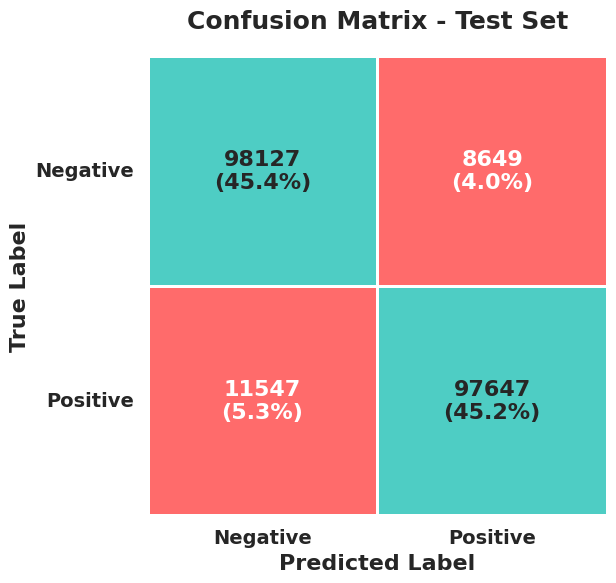

In [70]:
cm = np.array([[98127, 8649], [11547, 97647]])
labels = ["Negative", "Positive"]

cm_sum = np.sum(cm)
cm_percent = cm / cm_sum * 100

annot = np.empty_like(cm).astype(str)
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        annot[i, j] = f"{cm[i, j]}\n({cm_percent[i, j]:.1f}%)"

plt.figure(figsize=(7,6))
ax = sns.heatmap(
    cm,
    annot=annot,
    fmt='',
    cmap=sns.color_palette(["#FF6B6B", "#4ECDC4"], as_cmap=True),
    cbar=False,
    linewidths=2,
    linecolor='white',
    square=True,
    annot_kws={"fontsize":16, "weight":'bold'}
)

ax.set_xlabel('Predicted Label', fontsize=16, weight='bold')
ax.set_ylabel('True Label', fontsize=16, weight='bold')
ax.set_xticklabels(labels, fontsize=14, weight='bold')
ax.set_yticklabels(labels, fontsize=14, weight='bold', rotation=0)
ax.set_title('Confusion Matrix - Test Set', fontsize=18, weight='bold', pad=20)
plt.tight_layout()
plt.show()

In [66]:
print("Confusion Matrix:")
print("           Predicted Negative  Predicted Positive")
print(f"Actual Negative      {cm[0,0]}                 {cm[0,1]}")
print(f"Actual Positive      {cm[1,0]}                 {cm[1,1]}")

Confusion Matrix:
           Predicted Negative  Predicted Positive
Actual Negative      98127                 8649
Actual Positive      11547                 97647


#### **Insights from the Confusion Matrix**

|                 | Predicted Negative | Predicted Positive |
|-----------------|-------------------|-------------------|
| **True Negative** | 98,127 (24.6%)    | 8,649 (2.2%)      |
| **True Positive** | 11,547 (2.9%)     | 97,647 (24.5%)    |

- **High True Positives and True Negatives:**  
  The majority of samples are correctly classified, indicated by the large values on the diagonal (top-left and bottom-right). This means the model is very good at identifying both negative and positive sentiments.

- **Low Misclassification Rates:**  
  The off-diagonal values (false positives and false negatives) are relatively small, showing that the model rarely confuses the two classes.

- **Balanced Performance:**  
  The percentages are roughly equal for both classes, suggesting that the model does not have a strong bias toward one label over the other.

#### **Takeaway**

The confusion matrix confirms that our BERT-based sentiment classifier performs robustly on the test set, accurately distinguishing between positive and negative sentiments. The batch prediction approach makes the workflow scalable and efficient, while the visualization provides a clear and immediate understanding of model strengths and areas (albeit small) for improvement.

----
### Emotion Detection

To further enrich our analysis, we apply emotion detection models capable of identifying a range of emotional states (e.g., joy, anger, sadness, fear).

- **Approach:**  
  Pre-trained models or zero-shot classifiers are used to assign emotion labels to each comment or review.
- **Findings:**  
  The data reveals a spectrum of emotional responses, with certain topics eliciting distinct emotions.  
  This adds an additional layer of interpretability beyond binary sentiment.

---
## Integrated Insights & Takeaways

### 1. Multi-Dimensional View
- Visualization: Matrix or plot linking topics, sentiments, and emotions.

### 2. Highlighted Examples
- Table or panel with a few representative comments and their full breakdown.

### 3. Recommendations for Stakeholders

### 4. Limitations & Next Steps

### 5. (Optional) Interactive Exploration

## Conclusion (after this)


---
### Conclusion

By integrating modern NLP models, we achieve a more comprehensive and insightful analysis of text data. These techniques enable fine-grained understanding of public opinion and emotion, making them invaluable for real-world applications in business, research, and beyond.